# Danes on Planes
## Code for Forms of transport for vacation

In [1]:
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, Select, CustomJS, HoverTool, NumeralTickFormatter
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.palettes import PuBu, BuGn, PuBuGn
import pandas as pd


def load_and_prepare(filepath):
    df = pd.read_csv(filepath, encoding='unicode_escape', sep=';', header=None).drop(0, axis=1)
    df.columns = ['Duration', 'Type', 'Year', 'Vacations']
    df['Vacations'] = df['Vacations'].apply(lambda x: 0 if x == '..' else int(x))
    df = df[df['Duration'] == 'Mindst fire overnatninger'].drop('Duration', axis=1)
    df = df.pivot(index='Year', columns='Type', values='Vacations').reset_index()
    df = df.drop(columns=['Cykel', 'Sejlbåd'], errors='ignore')
    df = df.rename(columns={
        'Bil': 'Car', 'Tog': 'Train', 'Skib': 'Ship',
        'Fly': 'Airplane', 'Andre transportmidler': 'Other'
    })
    df['Year'] = df['Year'].astype(str)
    ordered_cols = ['Year', 'Airplane', 'Car', 'Train', 'Ship', 'Bus', 'Other']
    df = df[[col for col in ordered_cols if col in df.columns]]
    return df


# Load datasets
world_df = load_and_prepare('../data/transportation_world.csv')
dk_df = load_and_prepare('../data/transportation_dk.csv')

transportation_types = list(world_df.columns[1:])
#color_indices = [3, 1, 7, 5, 8, 0]
#colors = [PuBu[max(PuBu.keys())][i] for i in color_indices]
colors = [
    PuBu[9][1],
    BuGn[9][4],
    BuGn[9][1],
    PuBu[9][4],
    PuBuGn[9][6],
    PuBuGn[9][1],
]# Sources
source = ColumnDataSource(world_df)
source_world = ColumnDataSource(world_df)
source_dk = ColumnDataSource(dk_df)

# Create figure
p = figure(x_range=world_df["Year"], height=500, sizing_mode="stretch_width",
           title="Forms of transport for vacation",
           toolbar_location=None, tools="hover", tooltips="$name: @$name")

p.vbar_stack(transportation_types, x='Year', width=0.9, color=colors, source=source, legend_label=transportation_types)

hover = HoverTool(tooltips=[
    ("Transport type", "$name"),
    ("Year", "@Year"),
    ("Vacations", "@$name{0,0}")
])
p.tools = [hover]

p.y_range.start = 0
p.y_range.end = 5_500_000
p.yaxis.formatter = NumeralTickFormatter(format="0,0")
p.yaxis.axis_label = "Number of vacations"
p.xgrid.grid_line_color = None
p.xaxis.axis_label = "Year"
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "center"
p.add_layout(p.legend[0], 'left')

# Dropdown select
select = Select(title="Destination", value="World", options=["World", "Denmark"])

# JS callback
select.js_on_change("value", CustomJS(args=dict(source=source,
                                                source_world=source_world,
                                                source_dk=source_dk),
    code="""
    const selected = cb_obj.value;
    const new_data = selected === 'World' ? source_world.data : source_dk.data;
    const updated = {};
    for (const key in new_data) {
        updated[key] = [...new_data[key]];
    }
    source.data = updated;
    source.change.emit();
"""))

# Export to HTML
output_file("../assets_own/transportation_bokeh_plot.html", title="Vacation Transportation")

# Show with responsive layout
show(column(select, p, sizing_mode="stretch_width"))


## Departing Passengers from Danish Airports

In [2]:
# Load Data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv('../data/airplane_passengers_monthly.csv', encoding='unicode_escape', sep=';', header=None).drop(0, axis=1)
data.columns = ['str_date', 'passengers']
data['month'] = data['str_date'].apply(lambda x: int(x.split('M')[1]))
data['year'] = data['str_date'].apply(lambda x: int(x.split('M')[0]))
data = data[['year', 'month', 'passengers']]

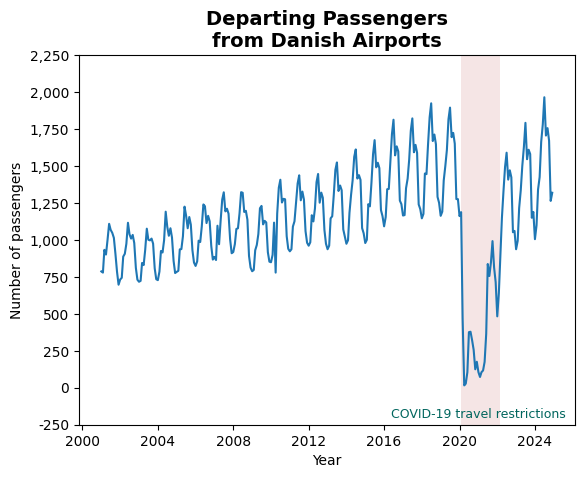

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

data['day'] = 1
data['date'] = pd.to_datetime(data[['day', 'month', 'year']])

# Your existing plot code
plt.plot(data['date'], data['passengers'])
plt.xlabel('Year')
plt.ylabel('Number of passengers')
plt.title('Departing Passengers\nfrom Danish Airports', fontsize=14, weight='bold')

# Format y-axis ticks (comma-separated thousands)
ax = plt.gca()
yticks = ax.get_yticks()
ax.set_yticks(yticks)  # Explicitly set the ticks
ax.set_yticklabels([f"{int(tick):,}" for tick in yticks])  # Adjusted for actual passenger values


# COVID-19 annotation (March 2020 - March 2022)
covid_start = '2020-02'
covid_end = '2022-03'
y_min = ax.get_ylim()[0]  # Bottom of the plot

# Add colored span (BuGn palette, semi-transparent)
ax.axvspan(covid_start, covid_end, color='#d17d7d', alpha=0.2, lw=0)

# Add label just above x-axis
label_y = y_min + (ax.get_ylim()[1] - y_min) * 0.01  # 2% above bottom
label_x = datetime(2021, 1, 1)  # January 2021 as datetime object
ax.text(label_x, label_y, 'COVID-19 travel restrictions', 
        ha='center', va='bottom', color='#01665e', fontsize=9)

plt.savefig('../assets_own/departing_passengers.png')
plt.show()

## Monthly travelling patterns

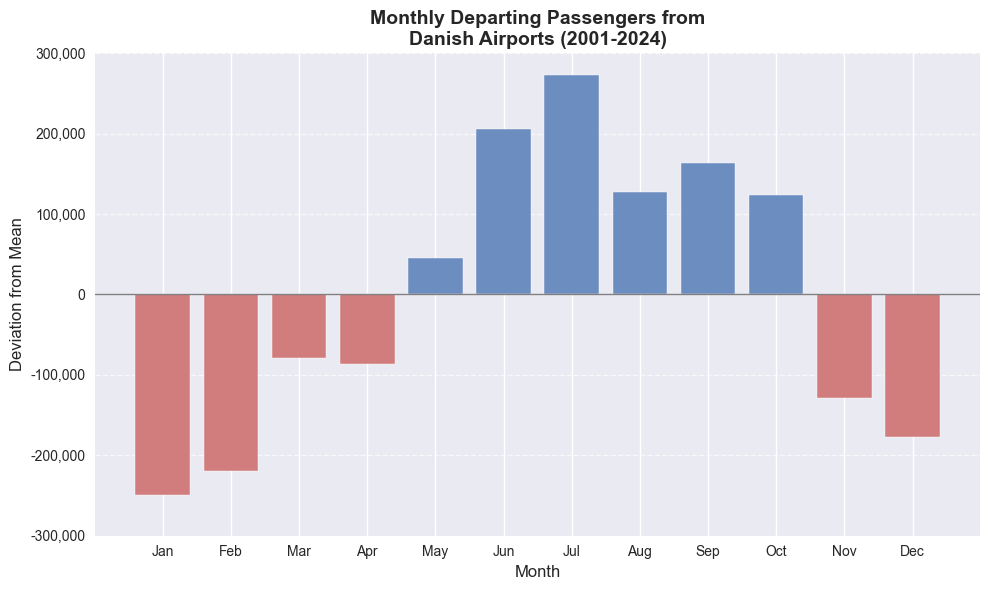

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10, 6))

positive_color = '#6c8dbf'
negative_color = '#d17d7d'

mean_monthly = pd.DataFrame(data.groupby(['month'])['passengers'].mean()).reset_index()
mean_monthly['mean_subtracted_passengers'] = (mean_monthly['passengers'] - mean_monthly['passengers'].mean())

colors = [positive_color if x > 0 else negative_color for x in mean_monthly['mean_subtracted_passengers']]

bars = plt.bar(mean_monthly['month'],
               mean_monthly['mean_subtracted_passengers'],
               edgecolor='white', color=colors)

plt.title('Monthly Departing Passengers from\nDanish Airports (2001-2024)', fontsize=14, weight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Deviation from Mean', fontsize=12)

plt.xticks(np.arange(1, 13),
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
           fontsize=10)

yticks = plt.yticks()[0]
plt.yticks(yticks, [f"{int(tick * 1000):,}" for tick in yticks])

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(0, color='gray', linewidth=1)
plt.tight_layout()

plt.savefig('../assets_own/popular_months.png')
plt.show()


# Danish Travel DNA: How and Where We Spend
## Code for Danish Travel Spending Patterns


In [ ]:
import pandas as pd
import numpy as np
import os
import json

# Make sure the output directory exists
# This directory will store the generated HTML file
os.makedirs('../assets', exist_ok=True)

# Load data from CSV files
# Assuming these files are located in a 'data' directory one level up from the script
try:
    socioeconomic = pd.read_csv('../data/socioeconomic.csv')
    consumption = pd.read_csv('../data/Consumption.csv')
    regions = pd.read_csv('../data/Region.csv')
except FileNotFoundError as e:
    print(f"Error loading data file: {e}")
    print("Please ensure 'socioeconomic.csv', 'Consumption.csv', and 'Region.csv' are in the '../data/' directory.")
    # In a real script, you might handle this more gracefully, but for this example, we'll exit
    exit()

# Define translations for Danish to English socioeconomic statuses
# This is used for clearer labeling in the radar charts
socio_translations = {
    "Gennemsnitshusstand": "Average Household",
    "Selvstændig": "Self-employed",
    "Lønmodtager på højeste niveau": "High Income",
    "Lønmodtager på mellemniveau": "Medium Income",
    "Lønmodtager på grundniveau": "Basic Income",
    "Arbejdsløs": "Unemployed",
    "Uddannelsessøgende": "Student",
    "Pensionist, efterlønsmodtager": "Pensioner",
    "Ude af erhverv i øvrigt": "Not in Workforce"
}

# Clean and process socioeconomic data
# Renaming columns and adding a translated group column
socio_df = socioeconomic.copy()
socio_df.columns = [col.strip() for col in socio_df.columns] # Remove leading/trailing whitespace from column names
socio_df = socio_df.rename(columns={
    'Socioøkonomisk status': 'Group',
    '09.8 Pakkerejser': 'Packages',
    '11.1 Restaurationstjenester': 'Restaurants',
    '11.2 Overnatningsfaciliteter': 'Accommodation'
})

# Add translated names
socio_df['Group_EN'] = socio_df['Group'].map(socio_translations)

# Handle any remaining NaN values
socio_df = socio_df.dropna(subset=['Group_EN'])  # Remove rows where Group_EN is NaN

# Calculate total spending
socio_df['Total'] = socio_df['Packages'] + socio_df['Restaurants'] + socio_df['Accommodation']

# Process consumption/age data
age_df = consumption.copy()
# Find the exact column names containing 'Package Holidays - Fixed Prices', etc.
try:
    package_col_age = [col for col in age_df.columns if 'Package Holidays - Fixed Prices' in col][0]
    restaurant_col_age = [col for col in age_df.columns if 'Restaurant Services - Fixed Prices' in col][0]
    accommodation_col_age = [col for col in age_df.columns if 'Accommodation Services - Fixed Prices' in col][0]
except IndexError:
    print("Error: Could not find expected 'Fixed Prices' columns in Consumption.csv.")
    print("Please check column names like 'Package Holidays - Fixed Prices'.")
    exit()

age_df = age_df.rename(columns={
    package_col_age: 'Packages',
    restaurant_col_age: 'Restaurants',
    accommodation_col_age: 'Accommodation',
    'AGE': 'Age Group' # Assuming 'AGE' is the column for age groups
})
age_df['Total'] = age_df['Packages'] + age_df['Restaurants'] + age_df['Accommodation'] # Calculate total spending

# Process region data
region_df = regions.copy()
# Find the exact column names containing 'Package Holidays - Fixed Prices', etc.
try:
    package_col_region = [col for col in region_df.columns if 'Package Holidays - Fixed Prices' in col][0]
    restaurant_col_region = [col for col in region_df.columns if 'Restaurant Services - Fixed Prices' in col][0]
    accommodation_col_region = [col for col in region_df.columns if 'Accommodation Services - Fixed Prices' in col][0]
except IndexError:
    print("Error: Could not find expected 'Fixed Prices' columns in Region.csv.")
    print("Please check column names like 'Package Holidays - Fixed Prices'.")
    exit()

region_df = region_df.rename(columns={
    package_col_region: 'Packages',
    restaurant_col_region: 'Restaurants',
    accommodation_col_region: 'Accommodation',
    'REGION': 'Region' # Assuming 'REGION' is the column for regions
})
region_df['Total'] = region_df['Packages'] + region_df['Restaurants'] + region_df['Accommodation'] # Calculate total spending

# Define vibrant colors for each spending category
category_colors = {
    'Packages': '#9b59b6',       # Amethyst (Vibrant Purple)
    'Restaurants': '#2ecc71',      # Emerald (Vibrant Green)
    'Accommodation': '#f1c40f'    # Sunflower (Vibrant Yellow)
}

# Define ENGLISH labels for the legend
english_labels = {
    'Packages': 'Package Holidays',
    'Restaurants': 'Restaurants',
    'Accommodation': 'Accommodation'
}

# Fixed maximum value for scaling
fixed_max = 25000

# Function to prepare data for Chart.js format
def prepare_chart_data(df, group_col, display_col=None):
    if display_col is None:
        display_col = group_col

    # Get the list of groups
    groups = df[display_col].tolist()

    # Prepare datasets for each category
    datasets = []

    # Create dataset for Restaurants (will be at bottom layer with lower opacity)
    restaurants_values = df['Restaurants'].tolist()
    restaurants_dataset = {
        'label': english_labels['Restaurants'],
        'data': restaurants_values,
        'backgroundColor': 'rgba(46, 204, 113, 0.5)',   # Green with medium opacity
        'borderColor': '#2ecc71',
        'borderWidth': 2,
        'pointBackgroundColor': '#2ecc71',
        'pointBorderColor': '#fff',
        'pointHoverBackgroundColor': '#fff',
        'pointHoverBorderColor': '#2ecc71',
        'order': 3   # Higher number = drawn first (bottom layer)
    }
    datasets.append(restaurants_dataset)

    # Create dataset for Packages (will be middle layer)
    packages_values = df['Packages'].tolist()
    packages_dataset = {
        'label': english_labels['Packages'],
        'data': packages_values,
        'backgroundColor': 'rgba(155, 89, 182, 0.6)',   # Purple with higher opacity
        'borderColor': '#9b59b6',
        'borderWidth': 2,
        'pointBackgroundColor': '#9b59b6',
        'pointBorderColor': '#fff',
        'pointHoverBackgroundColor': '#fff',
        'pointHoverBorderColor': '#9b59b6',
        'order': 2   # Middle layer
    }
    datasets.append(packages_dataset)

    # Create dataset for Accommodation (will be top layer with highest opacity)
    accommodation_values = df['Accommodation'].tolist()
    accommodation_dataset = {
        'label': english_labels['Accommodation'],
        'data': accommodation_values,
        'backgroundColor': 'rgba(241, 196, 15, 0.61)',   # Yellow with highest opacity
        'borderColor': '#f1c40f',
        'borderWidth': 2,
        'pointBackgroundColor': '#f1c40f',
        'pointBorderColor': '#fff',
        'pointHoverBackgroundColor': '#fff',
        'pointHoverBorderColor': '#f1c40f',
        'order': 1   # Lower number = drawn last (top layer)
    }
    datasets.append(accommodation_dataset)

    return {
        'labels': groups,
        'datasets': datasets
    }

# Prepare data for each chart
socioeconomic_data = prepare_chart_data(socio_df, 'Group', 'Group_EN')
age_data = prepare_chart_data(age_df, 'Age Group')
region_data = prepare_chart_data(region_df, 'Region')

# Create a dictionary with all chart data
chart_data = {
    'socioeconomic': socioeconomic_data,
    'age': age_data,
    'region': region_data
}

# Convert to JSON for use in the HTML
chart_data_json = json.dumps(chart_data)

# Create HTML template for the interactive radar chart
html_template = '''<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0, user-scalable=no">
    <title>Danish Travel Spending Patterns</title>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/Chart.js/3.9.1/chart.min.js"></script>
    <style>
        /* Ensure html and body fill the iframe and hide overflow */
        html, body {
            height: 100%; /* Makes html and body take 100% of iframe's height */
            width: 100%;
            margin: 0;
            padding: 0;
            overflow: hidden; /* Hides any scrollbars within the iframe */
        }
        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            padding: 0;
            background-color: transparent;

            /* Flexbox for vertical layout */
            display: flex;
            flex-direction: column;
        }
        .chart-container {
            position: relative;
            width: 100%;
            margin: 0 auto; /* Centers horizontally if width is less than 100%, but width is 100% here */
            background-color: white;
            padding: 0;
            overflow: hidden; /* Keep for internal canvas overflow */

            /* Flexbox for remaining space */
            flex-grow: 1; /* Allows it to take up all available vertical space */
            min-height: 0; /* Crucial for flex items to shrink and prevent overflow */
        }
        /* Ensure fixed height elements don't cause overflow by not shrinking */
        h1, .subtitle, .tab-container {
            flex-shrink: 0; /* Prevents these elements from shrinking */
        }

        /* Original styles for aesthetic elements */
        h1 {
            text-align: center;
            color: #333;
            margin: 10px 0;
        }
        .subtitle {
            text-align: center;
            color: #666;
            margin-bottom: 10px;
            font-style: italic;
        }
        .tab-container {
            display: flex;
            justify-content: center;
            margin-bottom: 20px;
        }
        .tab {
            padding: 12px 24px;
            background-color: #e0e0e0;
            border: none;
            cursor: pointer;
            font-size: 16px;
            font-weight: 500;
            transition: all 0.3s ease;
            border-radius: 4px;
            margin: 0 8px;
        }
        .tab.active {
            background-color: #3498db;
            color: white;
            box-shadow: 0 2px 8px rgba(52, 152, 219, 0.4);
        }
        .tab:hover:not(.active) {
            background-color: #d0d0d0;
        }
        /* Canvas sizing within chart-container */
        canvas {
            display: block; /* Ensures no extra space below the canvas */
            width: 100%; /* Chart.js responsive will adapt to parent width */
            height: 100%; /* Chart.js responsive will adapt to parent height */
        }
        @media (max-width: 768px) {
            .tab {
                padding: 8px 16px;
                font-size: 14px;
            }
        }
    </style>
</head>
<body>
    <h1>Danish Travel Spending Patterns</h1>
    <p class="subtitle">Explore how different Danish demographics allocate their travel budgets</p>

    <div class="tab-container">
        <button class="tab active" data-category="socioeconomic">Socioeconomic Groups</button>
        <button class="tab" data-category="age">Age Groups</button>
        <button class="tab" data-category="region">Regions</button>
    </div>

    <div class="chart-container">
        <canvas id="radarChart"></canvas>
    </div>

    <script>
        // Store chart instance for updating
        let radarChart;

        // Chart data from Python
        const chartData = CHART_DATA_PLACEHOLDER;

        // Fixed maximum value for scaling
        const fixedMaxValue = 25000;

        // Chart configuration
        const config = {
            type: 'radar',
            data: chartData.socioeconomic, // Initial dataset
            options: {
                responsive: true,
                maintainAspectRatio: false,
                plugins: {
                    legend: {
                        position: 'top',
                        reverse: true, // Reverse legend order to match visual order
                        labels: {
                            font: {
                                size: 14
                            },
                            padding: 20
                        }
                    },
                    title: {
                        display: true,
                        text: 'Socioeconomic Groups: Travel Spending Distribution',
                        font: {
                            size: 18,
                            weight: 'bold'
                        },
                        padding: {
                            top: 10,
                            bottom: 30
                        }
                    },
                    tooltip: {
                        callbacks: {
                            label: function(context) {
                                return ` ${context.dataset.label}: ${context.raw.toFixed(2)}`; // Display raw consumption value
                            }
                        }
                    }
                },
                scales: {
                    r: {
                        angleLines: {
                            color: '#cccccc'
                        },
                        grid: {
                            color: '#cccccc'
                        },
                        pointLabels: {
                            font: {
                                size: 14
                            },
                            color: '#555555'
                        },
                        ticks: {
                            backdropColor: 'transparent',
                            color: '#777777',
                            showLabelBackdrop: false,
                            font: {
                                size: 10
                            },
                            callback: function(value) {
                                return value.toFixed(0); // Format ticks as whole numbers
                            },
                            max: fixedMaxValue, // Set the fixed maximum value for the scale
                            min: 0,
                            stepSize: 5000 // Optional: Add step size for better readability
                        },
                        suggestedMin: 0,
                        suggestedMax: fixedMaxValue // Ensure suggested max is also set
                    }
                },
                elements: {
                    line: {
                        tension: 0.1 // Smoother lines
                    }
                }
            }
        };

        // Initialize the chart
        window.onload = function() {
            const ctx = document.getElementById('radarChart').getContext('2d');
            radarChart = new Chart(ctx, config);

            // Add event listeners to tabs using data attributes
            document.querySelectorAll('.tab').forEach(tab => {
                tab.addEventListener('click', function() {
                    const category = this.getAttribute('data-category');
                    showChart(category);
                });
            });
        };

        // Function to switch between datasets
        function showChart(category) {
            const titles = {
                socioeconomic: 'Socioeconomic Groups: Travel Spending Distribution',
                age: 'Age Groups: Travel Spending Distribution',
                region: 'Regions: Travel Spending Distribution'
            };

            // Update chart data
            radarChart.data = chartData[category];

            // Update chart title
            radarChart.options.plugins.title.text = titles[category];

            // Update the scale's max and suggestedMax when switching charts
            radarChart.options.scales.r.max = fixedMaxValue;
            radarChart.options.scales.r.suggestedMax = fixedMaxValue;

            // Update chart
            radarChart.update();

            // Update active tab
            document.querySelectorAll('.tab').forEach(tab => {
                if (tab.getAttribute('data-category') === category) {
                    tab.classList.add('active');
                } else {
                    tab.classList.remove('active');
                }
            });
        }
    </script>
</body>
</html>
'''

# Replace the placeholder with the actual JSON data
html_content = html_template.replace('CHART_DATA_PLACEHOLDER', chart_data_json)

# Write the HTML to a file
output_file = '../assets/danish_travel_radar_interactive.html'
with open(output_file, 'w', encoding='utf-8') as f:
    f.write(html_content)

# show the radar plot wihtout the need for a web serverin the note
webbrowser.open('file://' + os.path.realpath(output_file))



print(f"Interactive radar visualization created successfully and optimized for web fit with consistent scaling up to {fixed_max} at '{output_file}'!")

Radar plot HTML file created successfully!
Interactive radar visualization created successfully and optimized for web fit with consistent scaling up to 25000 at '../assets/danish_travel_radar_interactive.html'!


## Denmark's Tourism Position in Global Context (Interactive Bubble Plot)

In [18]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import os


# Make sure the output directory exists
# Assuming you run this from a script in a 'scripts' folder, and 'data' and 'assets' are siblings
os.makedirs('../assets', exist_ok=True)
data_file_path = '../data/bubble_plot.csv' # Ensure this path is correct

# Load the data
try:
    df = pd.read_csv(data_file_path)
except FileNotFoundError:
    print(f"Error: The data file was not found at {data_file_path}")
    print("Please ensure the path to 'bubble_plot.csv' is correct.")
    exit()

# Clean the data
df['GDP'] = pd.to_numeric(df['GDP, PPP (current international $) [NY.GDP.MKTP.PP.CD]'].str.replace(',', ''), errors='coerce')
df['Population'] = pd.to_numeric(df['Population, total [SP.POP.TOTL]'], errors='coerce')
df['Departures'] = pd.to_numeric(df['International tourism, number of departures [ST.INT.DPRT]'].str.replace(',', ''), errors='coerce')
df['PerCapita'] = pd.to_numeric(df['International Tourism Departures per capita'], errors='coerce')

# Calculate GDP per capita (new for x-axis)
df['GDP_Per_Capita'] = df['GDP'] / df['Population']

# Create continent mapping
continent_mapping = {
    'Denmark': 'Europe', 'Sweden': 'Europe', 'Norway': 'Europe', 'Finland': 'Europe', 'Iceland': 'Europe',
    'United Kingdom': 'Europe', 'Germany': 'Europe', 'France': 'Europe', 'Italy': 'Europe', 'Spain': 'Europe',
    'Netherlands': 'Europe', 'Belgium': 'Europe', 'Switzerland': 'Europe', 'Austria': 'Europe', 'Poland': 'Europe',
    'Czech Republic': 'Europe', 'Hungary': 'Europe', 'Romania': 'Europe', 'Portugal': 'Europe', 'Greece': 'Europe',
    'Ireland': 'Europe', 'Luxembourg': 'Europe', 'Slovenia': 'Europe', 'Croatia': 'Europe', 'Lithuania': 'Europe',
    'Latvia': 'Europe', 'Estonia': 'Europe', 'Slovakia': 'Europe', 'Bulgaria': 'Europe',
    'United States': 'North America', 'Canada': 'North America', 'Mexico': 'North America',
    'China': 'Asia', 'Japan': 'Asia', 'Korea, Rep.': 'Asia', 'India': 'Asia', 'Indonesia': 'Asia',
    'Singapore': 'Asia', 'Malaysia': 'Asia', 'Thailand': 'Asia', 'Vietnam': 'Asia', 'Philippines': 'Asia',
    'Hong Kong SAR, China': 'Asia', 'Russian Federation': 'Asia', 'Taiwan, China': 'Asia',
    'Australia': 'Oceania', 'New Zealand': 'Oceania',
    'South Africa': 'Africa', 'Egypt, Arab Rep.': 'Africa', 'Nigeria': 'Africa', 'Kenya': 'Africa', 'Morocco': 'Africa',
    'Brazil': 'South America', 'Argentina': 'South America', 'Chile': 'South America', 'Colombia': 'South America',
    'Peru': 'South America', 'Venezuela, RB': 'South America',
    'Saudi Arabia': 'Middle East', 'United Arab Emirates': 'Middle East', 'Turkey': 'Middle East', 'Israel': 'Middle East',
    'Albania': 'Europe', 'Belarus': 'Europe', 'Bosnia and Herzegovina': 'Europe', 'Kazakhstan': 'Asia',
    'Mongolia': 'Asia', 'North Korea': 'Asia', 'Sri Lanka': 'Asia', 'Pakistan': 'Asia', 'Bangladesh': 'Asia',
    'Myanmar': 'Asia', 'Nepal': 'Asia', 'Lebanon': 'Middle East', 'Jordan': 'Middle East', 'Kuwait': 'Middle East',
    'Bahrain': 'Middle East', 'Qatar': 'Middle East', 'Oman': 'Middle East', 'Yemen': 'Middle East',
    'Ethiopia': 'Africa', 'Ghana': 'Africa', 'Tanzania': 'Africa', 'Uganda': 'Africa', 'Zambia': 'Africa',
    'Zimbabwe': 'Africa', 'Cameroon': 'Africa', 'Senegal': 'Africa', 'Mali': 'Africa', 'Niger': 'Africa',
    'Chad': 'Africa', 'Sudan': 'Africa', 'Libya': 'Africa',
    'Tunisia': 'Africa', 'Algeria': 'Africa',
    'Ecuador': 'South America', 'Bolivia': 'South America', 'Paraguay': 'South America', 'Uruguay': 'South America',
    'Papua New Guinea': 'Oceania', 'Fiji': 'Oceania', 'Solomon Islands': 'Oceania'
}

df['Continent'] = df['Country Name'].map(continent_mapping).fillna('Other')
df_clean = df.dropna(subset=['GDP_Per_Capita', 'PerCapita', 'Population', 'Continent']).copy()
years = sorted(df_clean['Time'].unique())
years = [year for year in years if 1996 <= year <= 2019]

# Modern, more vibrant color scheme
continent_colors = {
    'Europe': '#3498db',         # Bright blue
    'North America': '#9b59b6',  # Purple
    'Asia': '#2ecc71',           # Green
    'Oceania': '#e74c3c',        # Red
    'Africa': '#f39c12',         # Orange
    'South America': '#1abc9c',  # Turquoise
    'Middle East': '#34495e'     # Dark blue-gray
}

df_clean = df_clean[df_clean['Continent'] != 'Other'].copy()

if df_clean.empty or not years:
    print("Dataframe is empty after cleaning or no valid years found. Cannot proceed.")
    exit()

df_clean['IsDenmark'] = df_clean['Country Name'] == 'Denmark'

# Create a function to calculate bubble sizes - SMALLER than before
def calculate_bubble_size(population):
    # Reduced scaling factor for smaller bubbles
    return np.sqrt(population / 6000000) * 5  # Further reduced from 6 to 5, and increased divisor

fig = go.Figure()
current_trace_idx = 0
# Add legend traces
for continent in continent_colors.keys():
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', name=continent,
                             marker=dict(size=8, color=continent_colors[continent]),
                             showlegend=True, legendgroup=continent))
    current_trace_idx += 1
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', name='🇩🇰 Denmark',
                         marker=dict(size=10, color='#003f5c', line=dict(width=2, color='#C60C30'), symbol='star'),
                         showlegend=True, legendgroup='Denmark'))
current_trace_idx += 1

data_trace_indices = []
continent_order_for_traces = []
first_year = years[0]

# Add initial data traces for the first year
for continent in continent_colors.keys():
    data_trace_indices.append(current_trace_idx)
    continent_order_for_traces.append(continent)
    continent_data_initial = df_clean[(df_clean['Time'] == first_year) & (df_clean['Continent'] == continent) & (~df_clean['IsDenmark'])]
    fig.add_trace(go.Scatter(
        x=continent_data_initial['GDP_Per_Capita'], y=continent_data_initial['PerCapita'],
        mode='markers', name=continent, text=continent_data_initial['Country Name'],
        hovertemplate='<b>%{text}</b><br>GDP per Capita: $%{x:,.0f}<br>Tourism/Capita: %{y:.2f}<br><extra></extra>',
        marker=dict(size=calculate_bubble_size(continent_data_initial['Population']) if not continent_data_initial.empty else [],
                    sizemin=3, color=continent_colors[continent], opacity=0.7, line=dict(width=0.5, color='white')),
        visible=True, legendgroup=continent, showlegend=False))
    current_trace_idx += 1

data_trace_indices.append(current_trace_idx)
continent_order_for_traces.append('Denmark')
denmark_data_initial = df_clean[(df_clean['Time'] == first_year) & (df_clean['IsDenmark'])]
fig.add_trace(go.Scatter(
    x=denmark_data_initial['GDP_Per_Capita'], y=denmark_data_initial['PerCapita'],
    mode='markers', name='Denmark', text=(['Denmark'] * len(denmark_data_initial)) if not denmark_data_initial.empty else [],
    hovertemplate='<b>Denmark</b><br>GDP per Capita: $%{x:,.0f}<br>Tourism/Capita: %{y:.2f}<br><extra></extra>',
    marker=dict(size=calculate_bubble_size(denmark_data_initial['Population']) if not denmark_data_initial.empty else [],
                color='#003f5c', line=dict(width=2, color='#C60C30'), symbol='star'),
    visible=True, legendgroup='Denmark', showlegend=False))

# --- Create Frames for Animation ---
plotly_frames = []
for year in years:
    frame_data_payload = []
    for continent_or_denmark in continent_order_for_traces:
        if continent_or_denmark == 'Denmark':
            current_year_data = df_clean[(df_clean['Time'] == year) & (df_clean['IsDenmark'])]
            marker_size = calculate_bubble_size(current_year_data['Population']).tolist() if not current_year_data.empty else []
            trace_update_dict = {'x': current_year_data['GDP_Per_Capita'].tolist(),
                                 'y': current_year_data['PerCapita'].tolist(),
                                 'marker': {'size': marker_size},
                                 'text': (['Denmark'] * len(current_year_data)) if not current_year_data.empty else []}
        else:
            current_year_data = df_clean[(df_clean['Time'] == year) & (df_clean['Continent'] == continent_or_denmark) & (~df_clean['IsDenmark'])]
            marker_size = calculate_bubble_size(current_year_data['Population']).tolist() if not current_year_data.empty else []
            trace_update_dict = {'x': current_year_data['GDP_Per_Capita'].tolist(),
                                 'y': current_year_data['PerCapita'].tolist(),
                                 'marker': {'size': marker_size},
                                 'text': current_year_data['Country Name'].tolist()}
        frame_data_payload.append(trace_update_dict)
    plotly_frames.append(go.Frame(data=frame_data_payload, name=str(year), traces=data_trace_indices))
fig.frames = plotly_frames

# Create slider steps
steps = []
for year in years:
    step = dict(
        method="animate",
        args=[[str(year)],
              {"frame": {"duration": 0, "redraw": True},
               "mode": "immediate",
               "transition": {"duration": 0}}
             ],
        label=str(year)
    )
    steps.append(step)

# Improved layout with GDP per capita on x-axis and optimized for no scrollbars
# INCREASED HEIGHT TO 650px and adjusted layout for more space
fig.update_layout(
    title={
        'text': "Denmark's Tourism Position in Global Context",
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 18}
    },
    xaxis=dict(
        title={"text": "GDP per Capita (USD, PPP)", 'font': {'size': 12}},
        type='log',
        range=[np.log10(max(0.01, df_clean['GDP_Per_Capita'].min(skipna=True) * 0.8 if pd.notna(df_clean['GDP_Per_Capita'].min(skipna=True)) else 0.01)),
               np.log10(max(1, df_clean['GDP_Per_Capita'].max(skipna=True) * 1.2 if pd.notna(df_clean['GDP_Per_Capita'].max(skipna=True)) else 1))],
        tickmode='array',
        tickvals=[1000, 5000, 10000, 50000, 100000],
        ticktext=['$1K', '$5K', '$10K', '$50K', '$100K'],
        showgrid=True,
        gridcolor='#eeeeee',
        tickfont={'size': 10}
    ),
    yaxis=dict(
        title={"text": "Tourism Departures per Capita", 'font': {'size': 12}},
        showgrid=True, 
        gridcolor='#eeeeee',
        range=[-0.1, 2.4],  # Slightly tighter range
        fixedrange=True,    # Prevents zoom/pan on y-axis
        tickfont={'size': 10}
    ),
    showlegend=True,
    legend=dict(
        orientation="h",          # Horizontal legend
        yanchor="top",
        y=1.12,                   # Moved higher above the plot to make more room
        xanchor="center",
        x=0.5,                    # Center horizontally
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="lightgray",
        borderwidth=1,
        itemsizing='constant',    # Keep marker sizes consistent
        font={'size': 10},        # Smaller font
        traceorder="normal"       # Normal trace order
    ),
    plot_bgcolor='white',
    width=None,                   # Let it be fully responsive
    height=700,                   # INCREASED HEIGHT from 550 to 650
    autosize=True,
    margin=dict(l=40, r=40, t=90, b=140),  # Increased top and bottom margins for controls
    annotations=[
        dict(
            x=0.98, y=0.02,
            xref="paper", yref="paper",
            text="Bubble size represents population",
            showarrow=False,
            font=dict(size=9, color="gray")
        )
    ],
    updatemenus=[{
        'type': 'buttons',
        'showactive': False,
        'y': -0.50,                # Moved down to avoid overlap
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'pad': {'t': 0, 'b': 0, 'r': 10},
        'buttons': [
            {'label': '▶️ Play', 'method': 'animate',
             'args': [None,
                      {'frame': {'duration': 800, 'redraw': True},
                       'fromcurrent': True,
                       'transition': {'duration': 300, 'easing': 'quadratic-in-out'},
                       'mode': 'immediate',
                       'autoplay': False}]},
            {'label': '⏸️ Pause', 'method': 'animate',
             'args': [[None],
                      {'frame': {'duration': 0, 'redraw': False},
                       'mode': 'immediate',
                       'transition': {'duration': 0}}]}
        ]
    }],
    sliders=[{
        'active': 0,
        'currentvalue': {
            'prefix': 'Year: ',
            'visible': True,
            'xanchor': 'center',
            'font': {'size': 12, 'color': '#333333'}
        },
        'pad': {'t': 30, 'b': 10}, # Increased padding at top
        'steps': steps,
        'len': 0.88,
        'x': 0.5,
        'xanchor': 'center',
        'y': -0.10,                # Adjusted position to avoid overlap with buttons
        'yanchor': 'top'
    }]
)

# Add a line trace showing the global median trend of GDP per Capita vs Tourism per Capita
median_by_year = df_clean.groupby('Time')[['GDP_Per_Capita', 'PerCapita']].median().reset_index()
fig.add_trace(go.Scatter(
    x=median_by_year['GDP_Per_Capita'],
    y=median_by_year['PerCapita'],
    mode='lines+markers',  # Added markers to make it hoverable
    line=dict(color='rgba(0,0,0,0.25)', width=1, dash='dot'),
    marker=dict(
        size=6,
        color='rgba(0,0,0,0.5)',
        symbol='circle',
        line=dict(color='rgba(0,0,0,0.2)', width=1)
    ),
    name='Global Median',  # Shortened name
    hovertemplate='<b>Global Median</b><br>Year: %{text}<br>GDP/Capita: $%{x:,.0f}<br>Tourism/Capita: %{y:.2f}<extra></extra>',
    text=median_by_year['Time'].astype(str),
    visible=True,
    showlegend=True
))

# Add a visual indicator for Denmark's path over time
denmark_data = df_clean[df_clean['IsDenmark']].sort_values('Time')
fig.add_trace(go.Scatter(
    x=denmark_data['GDP_Per_Capita'],
    y=denmark_data['PerCapita'],
    mode='lines',
    line=dict(color='rgba(198, 12, 48, 0.4)', width=1.5),
    name='DK Path',   # Shortened name
    hoverinfo='skip',
    visible=True,
    showlegend=True
))

# Create HTML with special container to prevent scrollbars
html_template = """<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0, user-scalable=no">
    <style>
        html, body {{
            height: 100%;
            width: 100%;
            margin: 0;
            padding: 0;
            overflow: hidden;
        }}
        #chart-container {{
            position: relative;
            height: 100%;
            width: 100%;
        }}
        .js-plotly-plot, .plot-container, .plotly {{
            height: 100%;
            width: 100%;
        }}
        .modebar {{
            top: 5px !important;
            right: 5px !important;
        }}
        /* Responsive adjustments */
        @media (max-width: 600px) {{
            .gtitle, .xtitle, .ytitle {{
                font-size: 10px !important;
            }}
            .xtick text, .ytick text {{
                font-size: 8px !important;
            }}
            .modebar-btn {{
                width: 20px !important;
                height: 20px !important;
            }}
            .legendtext {{
                font-size: 8px !important;
            }}
            .updatemenu-item-text {{
                font-size: 10px !important;
            }}
            .slidertext {{
                font-size: 10px !important;
            }}
        }}
    </style>
</head>
<body>
    <div id="chart-container">
        {plot_div}
    </div>
</body>
</html>
"""

# Write custom HTML to file
output_filename = '../assets/denmark_tourism_bubble_interactive.html'
with open(output_filename, 'w') as f:
    plotly_html = fig.to_html(
        include_plotlyjs='cdn',
        config={
            'responsive': True,
            'displayModeBar': True,
            'modeBarButtonsToRemove': [
                'lasso2d', 'select2d', 'autoScale2d',
                'hoverClosestCartesian', 'hoverCompareCartesian',
                'toggleSpikelines'
            ],
            'displaylogo': False,
            'scrollZoom': False,   # Disable scroll zooming to prevent accidental scrolling
            'showAxisDragHandles': False  # Disable axis drag to prevent scroll capture
        },
        full_html=False
    )
    f.write(html_template.format(plot_div=plotly_html))

# display bubblke plot in the note
import webbrowser
webbrowser.open('file://' + os.path.realpath(output_filename))

print(f"Responsive animated plot saved without scrollbars: {output_filename}")

Responsive animated plot saved without scrollbars: ../assets/denmark_tourism_bubble_interactive.html


# Beyond Borders

## Reasons for going on holidays outside of Denmark (Waffle chart)

C:\Users\Oscar\AppData\Local\Temp\ipykernel_5932\4089148367.py:38: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



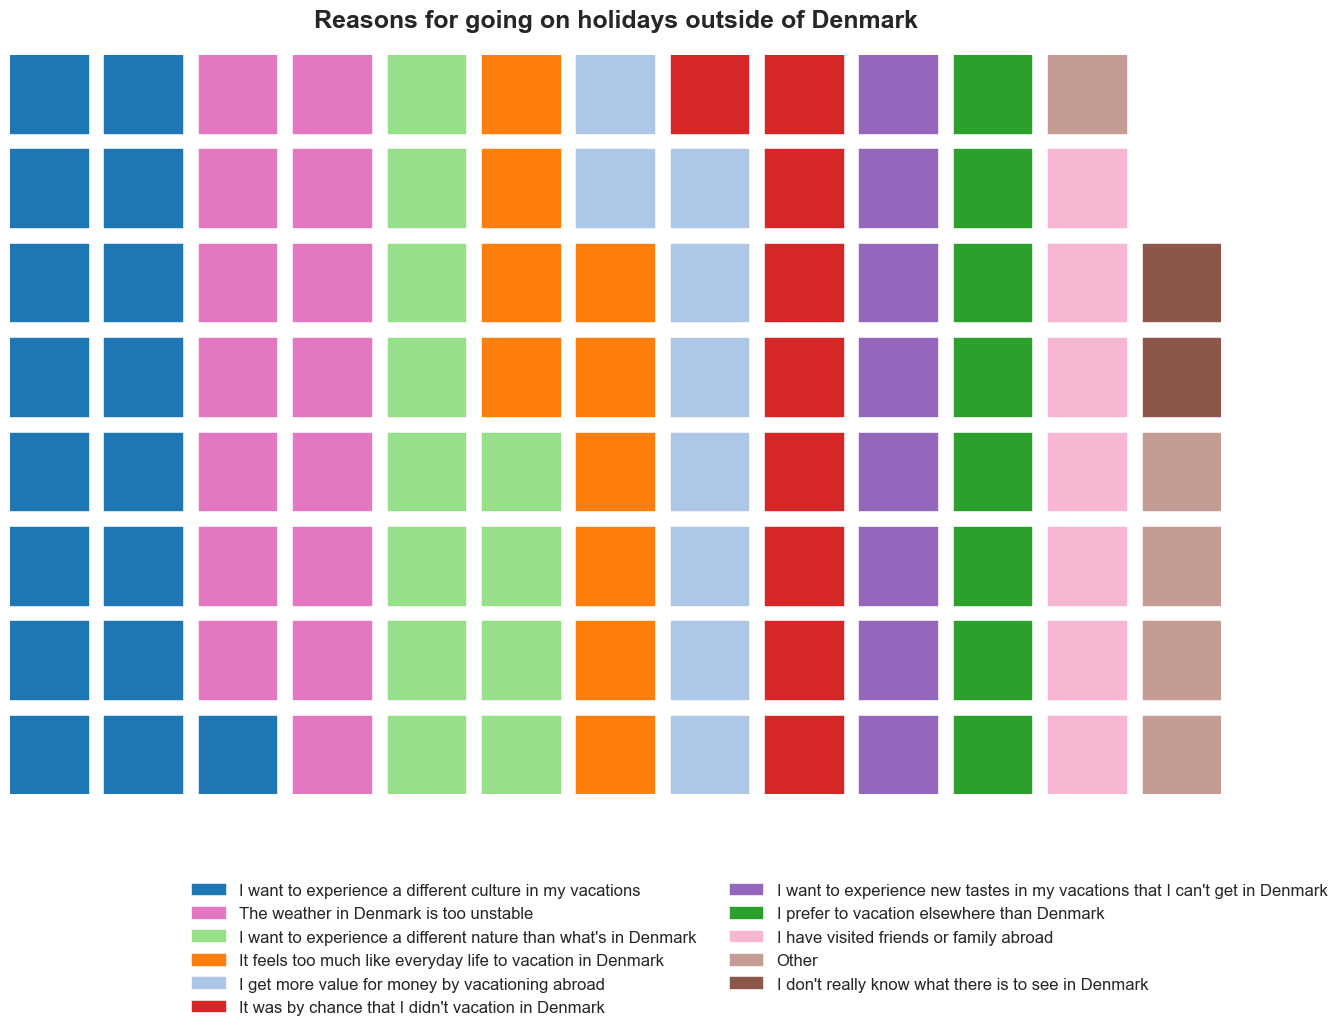

In [7]:
import pandas as pd
data = pd.read_csv('../data/reasons.csv')

reason_translation = {
    "Andet": "Other",
    "Jeg ved ikke rigtig, hvad der er at se i Danmark": "I don't really know what there is to see in Denmark",
    "Jeg har besøgt venner eller familie i udlandet": "I have visited friends or family abroad",
    "Jeg foretrækker at holde ferie andre steder end Danmark": "I prefer to vacation elsewhere than Denmark",
    "Jeg vil gerne opleve nye smagsoplevelser i mine ferier, og som jeg ikke kan få i Danmark": "I want to experience new tastes in my vacations that I can't get in Denmark",
    "Jeg får mere værdi for pengene ved at holde ferie i udlandet": "I get more value for money by vacationing abroad",
    "Det var tilfældigt, at jeg ikke holdt ferie i Danmark": "It was by chance that I didn't vacation in Denmark",
    "Det minder for meget om hverdagen at holde ferie i Danmark": "It feels too much like everyday life to vacation in Denmark",
    "Jeg vil gerne opleve en anden natur, end den der er i Danmark": "I want to experience a different nature than what's in Denmark",
    "Vejret i Danmark er for ustadigt – der er fx ingen sol- eller varmegaranti om sommeren": "The weather in Denmark is too unstable",
    "Jeg vil gerne opleve en anden kultur i mine ferier": "I want to experience a different culture in my vacations"
}

# Example of using the dictionary
data['Reason'] = data['Begrundelse'].map(reason_translation)
data = data[['Reason', 'Proportion']]
data = data.sort_values(by='Proportion', ascending=False)

from pywaffle import Waffle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex
import numpy as np

# Assuming 'data' is a DataFrame with 'Reason' and 'Proportion' columns
total_blocks = 100
data['Values'] = (data['Proportion'] * total_blocks).astype(int)

# Create dictionary for plotting
waffle_data = dict(zip(data['Reason'], data['Values']))

# Generate a muted color palette using a matplotlib colormap
# Let's use 'Set2' which is a nice soft, muted categorical palette
tab20 = cm.get_cmap('tab20')
desired_indices = [0, 12, 5, 2, 1, 6, 8, 4, 13, 11, 10]
colors = [rgb2hex(tab20(i / 19)) for i in desired_indices]


# Plotting the Waffle Chart
plt.figure(
    figsize=(20, 10),
    FigureClass=Waffle,
    rows=8,  # 4 rows of blocks
    columns=13,  # 25 columns of blocks
    values=waffle_data,
    colors=colors,  # Applying muted colors to the waffle blocks
    legend={'bbox_to_anchor': (1.1, -0.1), 'ncol': 2, 'fontsize':12},  # Position the legend outside the chart
)
plt.tight_layout()
plt.title('Reasons for going on holidays outside of Denmark', fontsize=18, fontweight='bold', pad=20)
plt.savefig('../assets_own/images/vacation_reason.png')
plt.show()
# Overskrift.
# Beskrivelse.
# Bedre farver. x

## Where to go (destination)

In [9]:
import plotly.express as px
from squarify import normalize_sizes, squarify
import pandas as pd
import numpy as np

data = pd.read_csv('../data/destinations.csv', sep=';', header=None).iloc[:,1:]

years = [f'20{i:02d}' for i in range(1, 24)]
data.columns = ['Lande'] + years
country_mapping = {
    'Belgien': 'Belgium',
    'Bulgarien': 'Bulgaria',
    'Cypern': 'Cyprus',
    'Estland': 'Estonia',
    'Finland': 'Finland',
    'Frankrig': 'France',
    'Færøerne': 'Faroe Islands',
    'Grækenland': 'Greece',
    'Grønland': 'Greenland',
    'Irland': 'Ireland',
    'Island': 'Iceland',
    'Italien': 'Italy',
    'Letland': 'Latvia',
    'Litauen': 'Lithuania',
    'Luxembourg': 'Luxembourg',
    'Malta': 'Malta',
    'Nederlandene': 'Netherlands',
    'Polen': 'Poland',
    'Portugal': 'Portugal',
    'Rumænien': 'Romania',
    'Rusland': 'Russia',
    'Schweiz': 'Switzerland',
    'Slovakiet': 'Slovakia',
    'Slovenien': 'Slovenia',
    'Spanien': 'Spain',
    'Storbritannien': 'UK',
    'Sverige': 'Sweden',
    'Norge': 'Norway',
    'Tjekkiet': 'Czech Republic',
    'Tyrkiet': 'Turkey',
    'Tyskland': 'Germany',
    'Ukraine': 'Ukraine',
    'Ungarn': 'Hungary',
    'Østrig': 'Austria',
    'Europa i øvrigt': 'Other Europe',
    'Sydafrika': 'South Africa',
    'Afrika uden Sydafrika': 'Other Africa',
    'Brasilien': 'Brazil',
    'Canada': 'Canada',
    'USA': 'USA',
    'Syd- og Mellemamerika uden Brasilien': 'Other South America',
    'Indien': 'India',
    'Japan': 'Japan',
    'Kina': 'China',
    'Sydkorea': 'South Korea',
    'Thailand': 'Thailand',
    'Asien uden Kina, Japan, Sydkorea, Indien og Thailand': 'Other Asia',
    'Australien': 'Australia',
    'Oceanien uden Australien': 'Oceania excluding Australia',
    'Uoplyst land': 'Unspecified country'
}

data['Country'] = data['Lande'].map(country_mapping)

continent_mapping = {
    # Europe
    'Belgium': 'Europe', 'Bulgaria': 'Europe', 'Cyprus': 'Europe',
    'Estonia': 'Europe', 'Finland': 'Europe', 'France': 'Europe',
    'Faroe Islands': 'Europe', 'Greece': 'Europe', 'Greenland': 'Europe',  
    'Ireland': 'Europe', 'Iceland': 'Europe', 'Italy': 'Europe',
    'Latvia': 'Europe', 'Lithuania': 'Europe', 'Luxembourg': 'Europe',
    'Malta': 'Europe', 'Netherlands': 'Europe', 'Poland': 'Europe',
    'Portugal': 'Europe', 'Romania': 'Europe', 'Russia': 'Asia',  
    'Switzerland': 'Europe', 'Slovakia': 'Europe', 'Slovenia': 'Europe',
    'Spain': 'Europe', 'UK': 'Europe', 'Sweden': 'Europe',
    'Norway': 'Europe', 'Czech Republic': 'Europe', 'Turkey': 'Europe',  
    'Germany': 'Europe', 'Ukraine': 'Europe', 'Hungary': 'Europe',
    'Austria': 'Europe', 'Other Europe': 'Europe',
    
    # Africa
    'South Africa': 'Africa', 'Other Africa': 'Africa',
    
    # Americas
    'Brazil': 'South America', 'Canada': 'North America', 'USA': 'North America',
    'Other South America': 'South America',
    
    # Asia
    'India': 'Asia', 'Japan': 'Asia', 'China': 'Asia',
    'South Korea': 'Asia', 'Thailand': 'Asia',
    'Other Asia': 'Asia',
    
    # Oceania
    'Australia': 'Oceania', 'Oceania excluding Australia': 'Oceania',
    
    # Other
    'Unspecified country': 'Unknown'
}

data['Continent'] = data['Country'].map(continent_mapping)


color_discrete_map = {
    # Europe
    '(?)': 'lightgrey',
    'Belgium': '#b9a394',        # dusty cocoa
    'Bulgaria': '#c9bca0',       # pale sand
    'Cyprus': '#d3a87c',         # dusty apricot
    'Estonia': '#8da7c4',        # muted steel blue
    'Finland': '#9eb1c9',        # soft arctic blue
    'France': '#748cab',         # dusty blue
    'Faroe Islands': '#8ea9b8',  # cool grey blue
    'Greece': '#7a9eab',         # sea slate
    'Greenland': '#d9c8b4',      # icy beige
    'Ireland': '#a2b29f',        # sage green
    'Iceland': '#b5c2bc',        # dusty teal
    'Italy': '#a09998',          # dusty olive
    'Latvia': '#a47160',         # muted russet
    'Lithuania': '#bba77e',      # faded ochre
    'Luxembourg': '#bfb8af',     # light ash
    'Malta': '#b4a19e',          # muted coral grey
    'Netherlands': '#c98474',    # dusty orange
    'Poland': '#c4a69f',         # pale rosewood
    'Portugal': '#d0826a',       # terracotta blush
    'Romania': '#c4b499',        # dusty parchment
    'Russia': '#949e9e',         # grey frost (Asia)
    'Switzerland': '#c56c6c',    # faded alpine red
    'Slovakia': '#b6b9c1',       # muted blue-grey
    'Slovenia': '#bfb6a3',       # stone beige
    'Spain': '#c05a5a',          # dusty red
    'UK': '#7e8b99',             # foggy navy
    'Sweden': '#a3b4a2',         # forest mist
    'Norway': '#9ba8aa',         # pine grey
    'Czech Republic': '#a89888', # dusty taupe
    'Turkey': '#c67f7f',         # faded terracotta
    'Germany': '#9e8c88',        # muted brown-grey
    'Ukraine': '#d0b562',        # wheat gold
    'Hungary': '#a78277',        # soft brick
    'Austria': '#c7a49c',        # faded blush
    'Other Europe': '#d6c8bb',   # light beige

    # Africa
    'South Africa': '#998f7b',       # earthy khaki
    'Other Africa': '#c6bfa2',       # dry savanna

    # Americas
    'Brazil': '#86a96f',             # dusty green
    'Canada': '#a16b5a',             # faded maple
    'USA': '#7a8690',                # grey denim
    'Other South America': '#b68265',# sunset clay

    # Asia
    'India': '#c29c5d',              # saffron dust
    'Japan': '#a68c94',              # muted sakura
    'China': '#b27c6d',              # dusty rose
    'South Korea': '#8ca0a5',        # cloudy grey-blue
    'Thailand': '#bda188',           # sepia cream
    'Other Asia': '#cabba5',         # parchment

    # Oceania
    'Australia': '#b29e8e',          # outback clay
    'Oceania excluding Australia': '#c2b39c',  # pale tan
}

data = data[['Country', 'Continent'] + years]
data = data.replace('..', 0)
data[years] = data[years].astype(int)

from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap

data = data[['Country', 'Continent', '2023']]
data = data[data['2023'] != 0]
continents = data['Continent'].unique()

sales_by_continent = data.groupby("Continent").sum("2023").sort_values(by="2023")

def treemap(df, col, x, y, dx, dy, *, N=100):
    sub_df = df.nlargest(N, col)
    normed = normalize_sizes(sub_df[col], dx, dy)
    blocks = squarify(normed, x, y, dx, dy)
    blocks_df = pd.DataFrame.from_dict(blocks).set_index(sub_df.index)
    return sub_df.join(blocks_df, how='left').reset_index()

x, y, w, h = 0, 0, 800, 450

blocks_by_continent = treemap(sales_by_continent, '2023', x, y, w, h )


dfs = []
for index, (Continent, Popularity, x, y, dx, dy) in blocks_by_continent.iterrows():
    df = data[data.Continent==Continent]
    dfs.append(treemap(df, "2023", x, y, dx, dy, N=10))
blocks = pd.concat(dfs)

color_discrete_map.update({
    'Italy': '#8aa786',         # dusty green (reflecting the green in the flag)
    'Norway': '#a05c63',        # muted red (flag-based, still subdued)
    'Sweden': '#cbb458',        # dusty yellow (flag's yellow in a muted tone)
    'Thailand': '#a184a2',      # dusty purple (aesthetic-friendly alternative)
    'Japan': '#c16868',         # soft red (evokes the red sun, in a dusty hue)
})

fig = px.treemap(
    data, 
    path=['Continent', 'Country'], 
    values='2023',
    color='Country',
    color_discrete_map=color_discrete_map
)

ids = fig.data[0]['ids']
labels = fig.data[0]['labels']
country_to_value = dict(zip(data['Country'], data['2023']))

# Construct hovertemplate per tile
hovertemplate = []
for label, id_ in zip(labels, ids):
    if '/' in id_:  # country node
        val = country_to_value.get(label, "")
        hovertemplate.append(f"<b>{label}</b><br>Proportion of total vacations: {val}%<extra></extra>")
    else:  # continent or root node
        hovertemplate.append(None)  # disables hover

fig.update_traces(
    hovertemplate=hovertemplate,
)

fig.write_html("../assets_own/destinations_treemap.html")
fig.show()

## Holiday Activities: Denmark vs. World

In [10]:
import pandas as pd
import plotly.graph_objects as go
import plotly.colors as pc

data = pd.read_csv('../data/activities.csv')
# Data
data = {
    'Category': [
        "Historical attractions, buildings and sights",
        "Museums and exhibitions",
        "Experience centers and amusement parks",
        "Animal parks, zoos and aquariums",
        "Local food experiences at markets or festivals etc.",
        "Water parks",
        "Concerts, music festivals or theater performances",
        "Other",
        "Sports events",
        "Don't know",
        "None of the above"
    ],
    'Denmark': [0.37, 0.32, 0.18, 0.17, 0.15, 0.11, 0.07, 0.06, 0.03, 0.02, 0.24],
    'World': [0.53, 0.34, 0.09, 0.09, 0.33, 0.07, 0.06, 0.08, 0.04, 0.01, 0.18]
}

df = pd.DataFrame(data)

# Normalize each country's values
df['Denmark'] = df['Denmark'] / df['Denmark'].sum()
df['World'] = df['World'] / df['World'].sum()

# Use a soft pastel color scale
colors = pc.qualitative.Prism
while len(colors) < len(df):  # Repeat colors if not enough
    colors += colors

# Create figure
fig = go.Figure()

# Add a bar for each category
for i, row in df.iterrows():
    fig.add_trace(go.Bar(
        y=['Denmark', 'World'],
        x=[row['Denmark'], row['World']],
        name=row['Category'],
        orientation='h',
        marker_color=colors[i],
        hovertemplate=f"<b>{row['Category']}</b><br>Popularity: %{{x:.0%}}<extra></extra>"
    ))

# Update layout
fig.update_layout(
    barmode='stack',
    title='Holiday Activities: Denmark vs. World',
    xaxis=dict(title='Proportion', tickformat='.0%'),
    yaxis=dict(categoryorder='array', categoryarray=['Denmark', 'World']),
    # legend=dict(
    #     orientation='v',
    #     yanchor='bottom',
    #     y=-0.6,
    #     xanchor='center',
    #     x=0.5,
    #     font=dict(size=10),
    #     traceorder='normal',
    #     itemwidth=80,
    #     itemsizing='constant'
    # ),
    # legend_itemclick=False,
    # legend_itemdoubleclick=False,
    showlegend=False,
    height=600
)
fig.write_html("../assets_own/activities_proportions.html", full_html=False, include_plotlyjs='cdn')
fig.show()


# Exploring the World: Recommendations for Danish Travelers

## Interactive World Map (Choropleth + Tripadvisor pins for Euorope)


In [ ]:
import folium
import pandas as pd
import branca.colormap as cm
import json
import requests
import io
from shapely.geometry import shape
import ast
import warnings

# Suppress the specific warnings for a cleaner output
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Load the CSV files
cost_df = pd.read_csv("../data/CostOfLiving.csv")
gpi_df = pd.read_csv("../data/GPI.csv")
temp_df = pd.read_csv("../data/combined_temperature.csv")

# Error here since tripadvisor data is not in the repo since it is too large so download from kaggle if you want to run this code: https://www.kaggle.com/datasets/damienbeneschi/krakow-ta-restaurans-data-raw/code
restaurants_df = pd.read_csv("../data/TA_restaurants_europa.csv")
CO2_df = pd.read_csv("../data/CO2Emission.csv")

# Clean CO2 data
CO2_df.columns = CO2_df.columns.str.strip()
CO2_df['Country'] = CO2_df['Country'].str.strip()

# Clean column names and country names for cost_df
cost_df.columns = cost_df.columns.str.strip()
cost_df['Country'] = cost_df['Country'].str.strip()  # Remove leading/trailing spaces

# Process temperature data to get the most recent year for each country
temp_df_latest = temp_df.sort_values('Year').groupby('Country').last().reset_index()
temp_df_latest = temp_df_latest[['Country', 'Annual Mean', 'Code']]
temp_df_latest.columns = ['Country', 'Annual_Mean_Temperature', 'iso3c']

# Process GPI data to get the most recent year for each country
gpi_latest = gpi_df[['Country', 'iso3c', '2023']]
gpi_latest.columns = ['Country', 'iso3c', 'GPI']

# Get list of countries from cost of living data
cost_countries = cost_df['Country'].unique()

# Define country name mapping
country_name_map = {
    'United States': 'United States of America',
    'Russia': 'Russian Federation',
    'South Korea': 'Korea, Republic of',
    'Iran': 'Iran, Islamic Republic of',
    'Vietnam': 'Viet Nam',
    'Venezuela': 'Venezuela, Bolivarian Republic of',
    'Tanzania': 'Tanzania, United Republic of',
    'Syria': 'Syrian Arab Republic',
    'Moldova': 'Moldova, Republic of',
    'Taiwan': 'Taiwan, Province of China',
    'Bolivia': 'Bolivia, Plurinational State of',
    'Ivory Coast': "Côte d'Ivoire",
    'North Macedonia': 'Macedonia, the former Yugoslav Republic of',
    'Libya': 'Libyan Arab Jamahiriya',
    'Bosnia And Herzegovina': 'Bosnia and Herzegovina',
    'Brunei': 'Brunei Darussalam',
    'United Kingdom': 'United Kingdom',
    'Us Virgin Islands': 'Virgin Islands, U.S.',
    'Hong Kong (China)': 'Hong Kong',
    'Macao (China)': 'Macao',
    'China': 'China',
    'Kosovo (Disputed Territory)': 'Kosovo',
    'Trinidad And Tobago': 'Trinidad and Tobago',
    'United Arab Emirates': 'United Arab Emirates',
    'Dominican Republic': 'Dominican Republic',
    'Czech Republic': 'Czech Republic',
    'New Zealand': 'New Zealand',
    'Costa Rica': 'Costa Rica',
    'El Salvador': 'El Salvador',
    'Saudi Arabia': 'Saudi Arabia',
    'South Africa': 'South Africa',
    'Papua New Guinea': 'Papua New Guinea',
    'Netherlands': 'Netherlands',
    'United States of America': 'United States',
    'Bahamas,': 'Bahamas',
    'Congo, Dem. Rep.': 'Democratic Republic of the Congo',
    'Iran, Islamic Rep.': 'Iran',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Korea, Rep.': 'South Korea',
    'Russian Federation': 'Russia',
    'Slovak Republic': 'Slovakia',
    'Syrian Arab Republic': 'Syria',
    'Yemen, Rep.': 'Yemen',
    'Venezuela, Rb': 'Venezuela',
    'Turkiye': 'Turkey',
    'Bosnia and Herzegovina': 'Bosnia And Herzegovina',
    'Trinidad and Tobago': 'Trinidad And Tobago',
    'United Arab Emirates': 'United Arab Emirates'
}

# Create comprehensive mappings to standardize to Cost of Living format
temperature_to_cost_map = {
    'United States': 'United States',
    'United Arab Emirates': 'United Arab Emirates', 
    'United Kingdom': 'United Kingdom',
    'Russian Federation': 'Russia',
    'Bahamas,': 'Bahamas',
    'Korea, Rep.': 'South Korea',
    'Korea-': 'South Korea',
    'Iran, Islamic Rep.': 'Iran',
    'Syrian Arab Republic': 'Syria',
    'Yemen, Rep.': 'Yemen',
    'Venezuela, Rb': 'Venezuela',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Slovak Republic': 'Slovakia',
    'Congo, Dem. Rep.': 'Democratic Republic of the Congo',
    'Timor Leste': 'Timor-Leste',
    'Cote d\'Ivoire': 'Ivory Coast',
    'Gambia,': 'Gambia',
    'Trinidad And Tobago': 'Trinidad And Tobago',
    'Guinea Bissau': 'Guinea-Bissau',
    'Bosnia And Herzegovina': 'Bosnia And Herzegovina',
    'Dominican Republic': 'Dominican Republic',
    'Czech Republic': 'Czech Republic',
    'Costa Rica': 'Costa Rica',
    'El Salvador': 'El Salvador',
    'Saudi Arabia': 'Saudi Arabia',
    'South Africa': 'South Africa',
    'Papua New Guinea': 'Papua New Guinea',
    'New Zealand': 'New Zealand',
    'Turkey': 'Turkey'
}

gpi_to_cost_map = {
    'United States of America': 'United States',
    'Bosnia and Herzegovina': 'Bosnia And Herzegovina',
    'Trinidad and Tobago': 'Trinidad And Tobago', 
    'Cote d\' Ivoire': 'Ivory Coast',
    'Democratic Republic of the Congo': 'Democratic Republic of the Congo',
    'Republic of the Congo': 'Republic of the Congo',
    'Czech Republic': 'Czech Republic',
    'Dominican Republic': 'Dominican Republic',
    'El Salvador': 'El Salvador',
    'Saudi Arabia': 'Saudi Arabia',
    'South Africa': 'South Africa',
    'Costa Rica': 'Costa Rica',
    'Papua New Guinea': 'Papua New Guinea',
    'New Zealand': 'New Zealand',
    'United Arab Emirates': 'United Arab Emirates',
    'United Kingdom': 'United Kingdom',
    'The Gambia': 'Gambia',
    'Timor-Leste': 'Timor-Leste',
    'North Macedonia': 'North Macedonia',
    'South Korea': 'South Korea',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Turkiye': 'Turkey',
    'Guinea-Bissau': 'Guinea-Bissau'
}

# CO2 to cost mapping
co2_to_cost_map = {
    'United States of America': 'United States',
    'Bosnia and Herzegovina': 'Bosnia And Herzegovina',
    'Trinidad and Tobago': 'Trinidad And Tobago',
    'Czech Republic': 'Czech Republic',
    'Dominican Republic': 'Dominican Republic',
    'Saudi Arabia': 'Saudi Arabia',
    'South Africa': 'South Africa',
    'Costa Rica': 'Costa Rica',
    'Papua New Guinea': 'Papua New Guinea',
    'New Zealand': 'New Zealand',
    'United Arab Emirates': 'United Arab Emirates',
    'United Kingdom': 'United Kingdom'
}

# Standardize temperature data
temp_df_latest_mapped = temp_df_latest.copy()
for index, row in temp_df_latest_mapped.iterrows():
    country = row['Country'].strip()
    # Apply mapping if exists, otherwise keep original
    standardized_country = temperature_to_cost_map.get(country, country)
    temp_df_latest_mapped.at[index, 'Country'] = standardized_country

# Filter temperature data to keep only countries in cost of living
temp_df_latest = temp_df_latest_mapped[temp_df_latest_mapped['Country'].str.strip().isin(cost_countries)]

# Standardize GPI data
gpi_latest_mapped = gpi_latest.copy()
for index, row in gpi_latest_mapped.iterrows():
    country = row['Country'].strip()
    # Apply mapping if exists, otherwise keep original
    standardized_country = gpi_to_cost_map.get(country, country)
    gpi_latest_mapped.at[index, 'Country'] = standardized_country

# Filter GPI data to keep only countries in cost of living
gpi_latest = gpi_latest_mapped[gpi_latest_mapped['Country'].str.strip().isin(cost_countries)]

# Standardize CO2 data
CO2_df_mapped = CO2_df.copy()
for index, row in CO2_df_mapped.iterrows():
    country = row['Country'].strip()
    # Apply mapping if exists, otherwise keep original
    standardized_country = co2_to_cost_map.get(country, country)
    CO2_df_mapped.at[index, 'Country'] = standardized_country

# Filter CO2 data to keep only countries in cost of living
CO2_df_latest = CO2_df_mapped

# Process restaurant data
# Convert cuisine styles string to list
restaurants_df['Cuisine Style'] = restaurants_df['Cuisine Style'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Create a list where each cuisine is a separate row
cuisines_list = []
for idx, row in restaurants_df.iterrows():
    for cuisine in row['Cuisine Style']:
        cuisines_list.append({
            'city': row['City'],
            'place': row['Name'],
            'cuisine_style': cuisine,
            'rating': row['Rating'],
            'reviews_number': row['Number of Reviews']
        })

cuisines_list = pd.DataFrame(cuisines_list)

# Calculate top options for each city
df_top_options = cuisines_list.groupby(['city', 'cuisine_style']).agg({"rating": "mean", "reviews_number": "sum"}).sort_values(by=['city', 'cuisine_style', "reviews_number", "rating"], ascending=False)
top_options = df_top_options.groupby('city').head(50).sort_values(by=['city', "reviews_number", "rating"], ascending=[True, False, False]).round(2)

# Create base map centered on Europe
world_map = folium.Map(
    location=[50, 10],  # Center on Europe
    zoom_start=4,  # Zoomed in on Europe
    tiles="OpenStreetMap", 
    scrollWheelZoom=True,
    control_scale=True,
    width='100%',
    height='100%'
)

# Define the GeoJSON URL
geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'

# Download the GeoJSON data
geo_data = requests.get(geojson_url).json()

# Define metrics with display names (in desired order)
# Changed: Removed Purchasing Power and added CO2, moved Restaurant Prices near Restaurant Information
metrics = [
    ('Cost of Living Index', 'Cost of Living Index'),
    ('GPI', 'Global Peace Index'),
    ('Rent Index', 'Rent Index'),
    ('Annual_Mean_Temperature', 'Temperature (°C)'),
    ('Groceries Index', 'Groceries Index'),
    ('CO2', 'CO2 Emissions (kg)'),
    ('Restaurant Price Index', 'Restaurant Prices'),
    ('restaurants', 'Restaurant Information')
]

# Get all unique countries from all datasets and GeoJSON
all_countries = set()
for feature in geo_data['features']:
    all_countries.add(feature['properties']['name'])

# Standardize country names in the DataFrames using copy() to avoid warnings
cost_df_mapped = cost_df.copy()
gpi_latest_mapped = gpi_latest.copy()
temp_df_latest_mapped = temp_df_latest.copy()
CO2_df_mapped = CO2_df_latest.copy()

for index, row in cost_df_mapped.iterrows():
    country = row['Country'].strip()
    if country in country_name_map:
        cost_df_mapped.at[index, 'Country_Mapped'] = country_name_map[country]
    else:
        cost_df_mapped.at[index, 'Country_Mapped'] = country

for index, row in gpi_latest_mapped.iterrows():
    country = row['Country'].strip()
    if country in country_name_map:
        gpi_latest_mapped.at[index, 'Country_Mapped'] = country_name_map[country]
    else:
        gpi_latest_mapped.at[index, 'Country_Mapped'] = country

for index, row in temp_df_latest_mapped.iterrows():
    country = row['Country'].strip()
    if country in country_name_map:
        temp_df_latest_mapped.at[index, 'Country_Mapped'] = country_name_map[country]
    else:
        temp_df_latest_mapped.at[index, 'Country_Mapped'] = country

for index, row in CO2_df_mapped.iterrows():
    country = row['Country'].strip()
    if country in country_name_map:
        CO2_df_mapped.at[index, 'Country_Mapped'] = country_name_map[country]
    else:
        CO2_df_mapped.at[index, 'Country_Mapped'] = country

# Create complete dataframes with all countries
complete_cost_df = cost_df_mapped.copy()
complete_gpi_df = gpi_latest_mapped.copy()
complete_temp_df = temp_df_latest_mapped.copy()
complete_co2_df = CO2_df_mapped.copy()

# Fill missing countries with proper null values
for country in all_countries:
    if country not in complete_cost_df['Country_Mapped'].values:
        new_row = pd.DataFrame({
            'Country_Mapped': [country], 
            'Cost of Living Index': [None], 
            'Rent Index': [None], 
            'Groceries Index': [None], 
            'Restaurant Price Index': [None]
        })
        complete_cost_df = pd.concat([complete_cost_df, new_row], ignore_index=True)
    
    if country not in complete_gpi_df['Country_Mapped'].values:
        new_row = pd.DataFrame({
            'Country_Mapped': [country], 
            'GPI': [None]
        })
        complete_gpi_df = pd.concat([complete_gpi_df, new_row], ignore_index=True)
    
    if country not in complete_temp_df['Country_Mapped'].values:
        new_row = pd.DataFrame({
            'Country_Mapped': [country], 
            'Annual_Mean_Temperature': [None]
        })
        complete_temp_df = pd.concat([complete_temp_df, new_row], ignore_index=True)
    
    if country not in complete_co2_df['Country_Mapped'].values:
        new_row = pd.DataFrame({
            'Country_Mapped': [country], 
            'CO2': [None]
        })
        complete_co2_df = pd.concat([complete_co2_df, new_row], ignore_index=True)

# Merge datasets
merged_df = complete_cost_df.merge(complete_gpi_df, on='Country_Mapped', how='outer', suffixes=('', '_gpi'))
merged_df = merged_df.merge(complete_temp_df, on='Country_Mapped', how='outer', suffixes=('', '_temp'))
merged_df = merged_df.merge(complete_co2_df, on='Country_Mapped', how='outer', suffixes=('', '_co2'))

# Make sure we're using the right country name when it exists in any dataset
merged_df['Country'] = merged_df['Country'].combine_first(merged_df['Country_gpi'] if 'Country_gpi' in merged_df.columns else pd.Series([None] * len(merged_df)))
merged_df['Country'] = merged_df['Country'].combine_first(merged_df['Country_temp'] if 'Country_temp' in merged_df.columns else pd.Series([None] * len(merged_df)))
merged_df['Country'] = merged_df['Country'].combine_first(merged_df['Country_co2'] if 'Country_co2' in merged_df.columns else pd.Series([None] * len(merged_df)))

# Normalize GPI to 0-100 scale (inverted since lower GPI is better)
if 'GPI' in merged_df.columns:
    gpi_values = merged_df['GPI'].dropna()
    if len(gpi_values) > 0:
        min_gpi = gpi_values.min()
        max_gpi = gpi_values.max()
        merged_df['Normalized_GPI'] = 100 * (max_gpi - merged_df['GPI']) / (max_gpi - min_gpi)

# We don't normalize temperature as it's already in a meaningful scale (degrees Celsius)
merged_df['Normalized_Annual_Mean_Temperature'] = merged_df['Annual_Mean_Temperature']

# We don't normalize CO2 as it's already in a meaningful scale (kg)
merged_df['Normalized_CO2'] = merged_df['CO2']

# Normalize other metrics to 0-100 scale
for col in ['Cost of Living Index', 'Rent Index', 'Groceries Index', 'Restaurant Price Index']:
    if col in merged_df.columns:
        col_values = merged_df[col].dropna()
        if len(col_values) > 0:
            min_val = col_values.min()
            max_val = col_values.max()
            if max_val > min_val:  # Avoid division by zero
                merged_df[f'Normalized_{col}'] = 100 * (merged_df[col] - min_val) / (max_val - min_val)

# Create mapping dict for tooltips with normalized data
country_data = {}
for _, row in merged_df.iterrows():
    try:
        country_mapped = row['Country_Mapped'] if pd.notna(row['Country_Mapped']) else None
        if country_mapped is not None:
            data_dict = {}
            
            # Add Cost of Living data if available
            if 'Cost of Living Index' in row and pd.notna(row['Cost of Living Index']):
                data_dict['Cost of Living Index'] = float(row['Cost of Living Index'])
                if 'Normalized_Cost of Living Index' in row and pd.notna(row['Normalized_Cost of Living Index']):
                    data_dict['Normalized_Cost of Living Index'] = float(row['Normalized_Cost of Living Index'])
            
            # Add GPI data if available
            if 'GPI' in row and pd.notna(row['GPI']):
                data_dict['GPI'] = float(row['GPI'])
                if 'Normalized_GPI' in row and pd.notna(row['Normalized_GPI']):
                    data_dict['Normalized_GPI'] = float(row['Normalized_GPI'])
            
            # Add Rent data if available
            if 'Rent Index' in row and pd.notna(row['Rent Index']):
                data_dict['Rent Index'] = float(row['Rent Index'])
                if 'Normalized_Rent Index' in row and pd.notna(row['Normalized_Rent Index']):
                    data_dict['Normalized_Rent Index'] = float(row['Normalized_Rent Index'])
            
            # Add Temperature data if available
            if 'Annual_Mean_Temperature' in row and pd.notna(row['Annual_Mean_Temperature']):
                data_dict['Annual_Mean_Temperature'] = float(row['Annual_Mean_Temperature'])
                data_dict['Normalized_Annual_Mean_Temperature'] = float(row['Annual_Mean_Temperature'])
            
            # Add Groceries data if available
            if 'Groceries Index' in row and pd.notna(row['Groceries Index']):
                data_dict['Groceries Index'] = float(row['Groceries Index'])
                if 'Normalized_Groceries Index' in row and pd.notna(row['Normalized_Groceries Index']):
                    data_dict['Normalized_Groceries Index'] = float(row['Normalized_Groceries Index'])
            
            # Add CO2 data if available
            if 'CO2' in row and pd.notna(row['CO2']):
                data_dict['CO2'] = float(row['CO2'])
                data_dict['Normalized_CO2'] = float(row['CO2'])
            
            # Add Restaurant data if available
            if 'Restaurant Price Index' in row and pd.notna(row['Restaurant Price Index']):
                data_dict['Restaurant Price Index'] = float(row['Restaurant Price Index'])
                if 'Normalized_Restaurant Price Index' in row and pd.notna(row['Normalized_Restaurant Price Index']):
                    data_dict['Normalized_Restaurant Price Index'] = float(row['Normalized_Restaurant Price Index'])
            
            country_data[country_mapped] = data_dict
    except Exception as e:
        print(f"Error processing row: {e}")

# English display names for some countries that might have non-English names
english_country_names = {
    'Deutschland': 'Germany',
    'España': 'Spain',
    'Россия': 'Russia',
    'Polska': 'Poland',
    'Česko': 'Czech Republic',
    'Österreich': 'Austria',
    'Schweiz': 'Switzerland',
    'Sverige': 'Sweden',
    'Suomi': 'Finland',
    'Norge': 'Norway',
    'Danmark': 'Denmark',
    'Nederland': 'Netherlands',
    'Belgique': 'Belgium',
    'Ελλάδα': 'Greece',
    'България': 'Bulgaria',
    'România': 'Romania',
    'Magyarország': 'Hungary',
    'Slovensko': 'Slovakia',
    'Hrvatska': 'Croatia',
    'Србија': 'Serbia',
    'Ísland': 'Iceland',
    'Slovenija': 'Slovenia',
    'Latvija': 'Latvia',
    'Eesti': 'Estonia',
    'Lietuva': 'Lithuania',
    'Κύπρος': 'Cyprus',
    'Lëtzebuerg': 'Luxembourg',
    'Malta': 'Malta',
    '日本': 'Japan',
    '中国': 'China',
    '대한민국': 'South Korea',
    'भारत': 'India',
    'ประเทศไทย': 'Thailand',
    'Việt Nam': 'Vietnam',
    'Indonesia': 'Indonesia',
    'Россия': 'Russia',
    'Украина': 'Ukraine',
    'Беларусь': 'Belarus',
    'Brasil': 'Brazil',
    'México': 'Mexico',
    'Argentina': 'Argentina',
    'Chile': 'Chile',
    'Perú': 'Peru',
    'Colombia': 'Colombia',
    'Venezuela': 'Venezuela',
    'Türkiye': 'Turkey',
    'مصر': 'Egypt',
    'المغرب': 'Morocco',
    'الجزائر': 'Algeria',
    'تونس': 'Tunisia',
    'ليبيا': 'Libya',
    'السعودية': 'Saudi Arabia',
    'الإمارات': 'UAE',
    'قطر': 'Qatar',
    'الكويت': 'Kuwait',
    'عمان': 'Oman',
    'البحرين': 'Bahrain',
    'لبنان': 'Lebanon',
    'الأردن': 'Jordan',
    'سوريا': 'Syria',
    'العراق': 'Iraq',
    'إيران': 'Iran'
}

# Define city coordinates with flags
map_cities = {
    'Amsterdam': {
        'lat': 52.3547,
        'lon': 4.7638,
        'flag': 'https://i.imgur.com/blc3acB.png'
    },
    'Athens': {
        'lat': 37.9908,
        'lon': 23.7033,
        'flag': 'https://i.imgur.com/EGGLpd1.png'
    },
    'Barcelona': {
        'lat': 41.3948,
        'lon': 2.0787,
        'flag': 'https://i.imgur.com/vUh0XT5.png'
    }, 
    "Berlin": {
        'lat': 52.5069, 
        'lon': 13.3345,
        'flag': 'https://i.imgur.com/IWmwjUA.png'
    },
    "Bratislava": {
        'lat': 48.1359, 
        'lon': 16.9758,
        'flag': 'https://i.imgur.com/48ARppO.png'
    },              
    "Brussels": {
        'lat': 50.8550, 
        'lon': 4.3053,
        'flag': 'https://i.imgur.com/8dsgG0Z.png'
    },              
    "Budapest": {
        'lat': 47.4813, 
        'lon': 18.9902,
        'flag': 'https://i.imgur.com/3wn3zdO.png'
    },              
    "Copenhagen": {
        'lat': 55.6713, 
        'lon': 12.4537,
        'flag': 'https://i.imgur.com/6qIQO7a.png'
    },                
    "Dublin": {
        'lat': 53.3244, 
        'lon': -6.3857,
        'flag': 'https://i.imgur.com/XKBE096.png'
    },
    "Edinburgh": {
        'lat': 55.941, 
        'lon': -3.2753,
        'flag': 'https://i.imgur.com/D0M33Pp.png'
    },
    "Geneva": {
        'lat': 46.2050, 
        'lon': 6.1090,
        'flag': 'https://i.imgur.com/bYvB2U5.png'
    },
    "Hamburg": {
        'lat': 53.5586, 
        'lon': 9.6476,
        'flag': 'https://i.imgur.com/IWmwjUA.png'
    },
    "Helsinki": {
        'lat': 60.1100, 
        'lon': 24.7385,
        'flag': 'https://i.imgur.com/RMgJjUZ.png'
    },
    "Krakow": {
        'lat': 50.0469, 
        'lon': 19.8647,
        'flag': 'https://i.imgur.com/Pz2wDfL.png'
    },
    "Lisbon": {
        'lat': 38.7437, 
        'lon': -9.2302,
        'flag': 'https://i.imgur.com/u0PAGku.png'
    },
    "Ljubljana": {
        'lat': 46.06627, 
        'lon': 14.3920,
        'flag': 'https://i.imgur.com/SaeK70A.png'
    },
    "London": {
        'lat': 51.5287, 
        'lon': -0.3817,
        'flag': 'https://i.imgur.com/82dLnLB.png'
    },
    "Luxembourg": {
        'lat': 49.8148, 
        'lon': 5.5728,
        'flag': 'https://i.imgur.com/jKBqD0Z.png'
    },
    "Lyon": {
        'lat': 45.7580, 
        'lon': 4.7650,
        'flag': 'https://i.imgur.com/7vrY3jL.png'
    },
    "Madrid": {
        'lat': 40.4381, 
        'lon': -3.8196,
        'flag': 'https://i.imgur.com/vUh0XT5.png'
    },
    "Milan": {
        'lat': 45.4628, 
        'lon': 9.1076,
        'flag': 'https://i.imgur.com/9ciRLpM.png'
    },
    "Munich": {
        'lat': 48.1550, 
        'lon': 11.4017,
        'flag': 'https://i.imgur.com/IWmwjUA.png'
    },
    "Oporto": {
        'lat': 41.1622, 
        'lon': -8.6919,
        'flag': 'https://i.imgur.com/u0PAGku.png'
    },
    "Oslo": {
        'lat': 59.8939, 
        'lon': 10.6450,
        'flag': 'https://i.imgur.com/FM8gW1N.png'
    },
    "Paris": {
        'lat': 48.8589, 
        'lon': 2.2770,
        'flag': 'https://i.imgur.com/7vrY3jL.png'
    },
    "Prague": {
        'lat': 50.0598, 
        'lon': 14.3255,
        'flag': 'https://i.imgur.com/1gDnRgD.png'
    },
    'Rome': {
        'lat': 41.9102,
        'lon': 12.3959,
        'flag': 'https://i.imgur.com/9ciRLpM.png'
    },
    "Stockholm": {
        'lat': 59.3262, 
        'lon': 17.8419,
        'flag': 'https://i.imgur.com/VSHZpY9.png'
    },
    "Vienna": {
        'lat': 48.2208, 
        'lon': 16.2399,
        'flag': 'https://i.imgur.com/xRyqWqH.png'
    },
     "Warsaw": {
        'lat': 52.2330, 
        'lon': 20.7810,
        'flag': 'https://i.imgur.com/Pz2wDfL.png'
    },
     "Zurich": {
        'lat': 47.3775, 
        'lon': 8.4666,
        'flag': 'https://i.imgur.com/bYvB2U5.png'
    }             
}

# Default to show Cost of Living Index first
default_metric = 'Cost of Living Index'
default_title = 'Cost of Living Index'

# Create a container for the colorbar
colorbar_div = folium.Element("""
<div id="dynamic-colorbar" style="position:fixed; right:20px; bottom:20px; z-index:9999; background:white; padding:5px; border-radius:5px; box-shadow: 0 0 10px rgba(0,0,0,0.2);"></div>
""")
world_map.get_root().html.add_child(colorbar_div)

# Define different color schemes for each metric
color_schemes = {
    'Cost of Living Index': ['#ffcccc', '#ffb3b3', '#ff9999', '#ff8080', '#ff4d4d', '#cc0000'],
    'GPI': ['#e6ccb3', '#d9b38c', '#cc9966', '#bf8040', '#995c00', '#663d00'],
    'Rent Index': ['#e6ccff', '#d9b3ff', '#cc99ff', '#b366ff', '#9933ff', '#6600cc'],
    'Annual_Mean_Temperature': ['#cce6ff', '#99ccff', '#66b3ff', '#3399ff', '#0080ff', '#004d99'],
    'Groceries Index': ['#ccffcc', '#99ff99', '#66ff66', '#33cc33', '#00b300', '#006600'],
    'CO2': ['#FFE4B5', '#FFDAB9', '#FFA500', '#FF8C00', '#FF7F50', '#FF4500'],
    'Restaurant Price Index': ['#ffcce6', '#ff99cc', '#ff66b3', '#ff3399', '#cc0066', '#990066']
}

# Define which metrics should use inverted color scales
inverted_metrics = ['GPI']

# Create colormaps for each metric
colormaps = {}
colorbar_htmls = {}

for col, title in metrics:
    if col != 'restaurants':  # Skip restaurants as it doesn't have a colormap
        # Use the normalized column
        norm_col = f'Normalized_{col}'
        
        # Set fixed min/max for normalized data (0-100)
        vmin = 0
        vmax = 100
        
        # Get the color scheme for this metric
        colors = color_schemes[col]
        
        # For temperature and CO2, use actual range (not normalized)
        if col == 'Annual_Mean_Temperature':
            # Use a simple linear scale for temperature with fixed endpoints
            temp_min = -10
            temp_max = 30
            
            # Create a linear colormap with fixed temperature range
            colormap = cm.LinearColormap(
                colors=colors,
                vmin=temp_min,
                vmax=temp_max,
                caption=f"{title}"
            )
        elif col == 'CO2':
            # Use actual CO2 values
            co2_min = 0
            co2_max = 5000  # Set max based on data range
            
            # Create a linear colormap with fixed CO2 range
            colormap = cm.LinearColormap(
                colors=colors,
                vmin=co2_min,
                vmax=co2_max,
                caption=f"{title}"
            )
        else:
            # Create fixed steps for the color scale
            steps = [0, 20, 40, 60, 80, 100]
            
            # Choose color order based on metric type
            colormap = cm.LinearColormap(
                colors=colors,
                index=steps,
                vmin=vmin,
                vmax=vmax,
                caption=f"{title}"
            )
        
        colormaps[col] = colormap
        # Store colorbar HTML for this metric
        colorbar_htmls[title] = colormap._repr_html_()

# Create a feature group for each metric
feature_groups = {}
for col, title in metrics:
    # Create a feature group
    fg = folium.FeatureGroup(name=title, show=(title == default_title))
    feature_groups[title] = fg
    
    if col == 'restaurants':
        # Add restaurant information markers at country centers
        def get_flag(city):
            flag = map_cities.get(city)
            if flag:
                flag_url = flag['flag']
                return(flag_url)
            return ""

        def get_top_options2(city):
            opt = top_options[top_options.index.get_level_values('city').isin([city])][:3]
            opt = opt.reset_index()
            opt = opt.sort_values(by=["rating", "reviews_number"], ascending=[False, False])
            top_3 = ""
            icon_class = ""
            for i in opt.iterrows():
                if (i[1]['cuisine_style'] == "Gluten Free Options") or (i[1]['cuisine_style'] == "Vegan Options"):
                    icon_class = "fa-pagelines"
                elif i[1]['cuisine_style'] == "Vegetarian Friendly":
                    icon_class = "fa-tree"
                else:
                    icon_class = "fa-globe"
                top_3 += "<div  style =\"height:25px;\"><i class=\"fa "+ icon_class + "\"></i>&nbsp;" + i[1]['cuisine_style'] + "&nbsp;" + str(i[1]['rating']) + " (" + str(i[1]['reviews_number']) +  " reviews)</div>"
            return(top_3)
        
        for k, v in map_cities.items():
            flag = get_flag(k)
            html =  "<!DOCTYPE html><html><head><link rel=\"stylesheet\" href=\"https://cdnjs.cloudflare.com/ajax/libs/font-awesome/4.7.0/css/font-awesome.min.css\"></head><body>"
            html += "<div><div style =\"height:30px;\"><strong>{}</strong>&nbsp;<img src='{}' width='18px' height='18px'></div><div>{}</div>".format(k, flag, get_top_options2(k))
            html += "</body></html>"    
            iframe = folium.IFrame(html, width=(300)+20, height=(110)+20)
            popup = folium.Popup(iframe, max_width=1000)    
            
            folium.Marker(location =[v['lat'], v['lon']], 
                        popup=popup,
                        icon = folium.Icon(color='darkpurple', icon='fa-cutlery', prefix='fa')
            ).add_to(fg)
    else:
        # Use normalized column
        norm_col = f'Normalized_{col}'
        
        # Define a style function for this metric with strict data checking
        def style_function(feature, col=col, norm_col=norm_col, colormap=colormaps[col]):
            country_name = feature['properties']['name']
            # Only apply color if country exists in data AND has value for this metric
            if country_name in country_data:
                data = country_data[country_name]
                
                # Check for temperature and CO2 (not normalized)
                if col in ['Annual_Mean_Temperature', 'CO2']:
                    if col in data and data[col] is not None and not pd.isna(data[col]):
                        return {
                            'fillColor': colormap(data[col]),
                            'color': 'black',
                            'weight': 0.5,
                            'fillOpacity': 0.7
                        }
                
                # Check for other metrics (normalized)
                elif norm_col in data and data[norm_col] is not None and not pd.isna(data[norm_col]):
                    return {
                        'fillColor': colormap(data[norm_col]),
                        'color': 'black',
                        'weight': 0.5,
                        'fillOpacity': 0.7
                    }
            
            # No data available - use gray
            return {
                'fillColor': '#d3d3d3', 
                'color': 'black', 
                'weight': 0.5, 
                'fillOpacity': 0.5
            }

        # Create a tooltip function for this layer and metric
        def tooltip_function(feature, col=col, norm_col=norm_col, title=title):
            country_name = feature['properties']['name']
            
            # Use English name if available
            display_name = english_country_names.get(country_name, country_name)
            
            if country_name in country_data:
                data = country_data[country_name]
                
                # Build a popup with available data
                popup_content = f"""
                <div style="min-width:200px">
                    <h4 style="margin:0 0 5px;padding-bottom:5px;border-bottom:1px solid #ccc; font-weight:bold; font-size:16px;">{display_name}</h4>
                    <table style="width:100%;border-collapse:collapse;font-size:13px; margin-top:5px;">
                """
                
                # Show whether current metric is available
                metric_available = False
                current_value = None
                
                if col in ['Annual_Mean_Temperature', 'CO2']:
                    if col in data and pd.notna(data[col]):
                        metric_available = True
                        current_value = data[col]
                else:
                    if col in data and pd.notna(data[col]):
                        metric_available = True
                        current_value = data[col]
                
                # Add available metrics to popup
                if 'Cost of Living Index' in data and pd.notna(data['Cost of Living Index']):
                    popup_content += f"<tr><td><b>Cost of Living:</b></td><td align='right'>{data['Cost of Living Index']:.1f}</td></tr>"
                
                if 'GPI' in data and pd.notna(data['GPI']):
                    popup_content += f"<tr><td><b>Peace Index:</b></td><td align='right'>{data['GPI']:.3f}</td></tr>"
                
                if 'Rent Index' in data and pd.notna(data['Rent Index']):
                    popup_content += f"<tr><td><b>Rent:</b></td><td align='right'>{data['Rent Index']:.1f}</td></tr>"
                
                if 'Annual_Mean_Temperature' in data and pd.notna(data['Annual_Mean_Temperature']):
                    popup_content += f"<tr><td><b>Temperature:</b></td><td align='right'>{data['Annual_Mean_Temperature']:.1f}°C</td></tr>"
                
                if 'Groceries Index' in data and pd.notna(data['Groceries Index']):
                    popup_content += f"<tr><td><b>Groceries:</b></td><td align='right'>{data['Groceries Index']:.1f}</td></tr>"
                
                if 'CO2' in data and pd.notna(data['CO2']):
                    popup_content += f"<tr><td><b>CO2 Emissions:</b></td><td align='right'>{data['CO2']:.0f} kg</td></tr>"
                
                if 'Restaurant Price Index' in data and pd.notna(data['Restaurant Price Index']):
                    popup_content += f"<tr><td><b>Restaurant:</b></td><td align='right'>{data['Restaurant Price Index']:.1f}</td></tr>"
                
                # Warn if current metric is not available
                if not metric_available:
                    popup_content += f"""
                        <tr><td colspan='2' style='color:red; font-weight:bold; padding-top:10px;'>
                            Current metric ({title}) not available
                        </td></tr>
                    """
                
                popup_content += """
                    </table>
                    <div style="margin-top:8px;font-weight:bold;color:#c00; font-size:14px;">
                        Current View: """ + title
                
                if metric_available and current_value is not None:
                    if col == 'Annual_Mean_Temperature':
                        popup_content += f" ({current_value:.1f}°C)"
                    elif col == 'CO2':
                        popup_content += f" ({current_value:.0f} kg)"
                    elif col == 'GPI':
                        popup_content += f" ({current_value:.3f})"
                    else:
                        popup_content += f" ({current_value:.1f})"
                else:
                    popup_content += " (No data)"
                
                popup_content += """
                    </div>
                </div>
                """
                
                return popup_content
            else:
                return f"<b>{display_name}</b><br>No data available"

        # Add the GeoJSON layer with styling for this metric
        geo_json = folium.GeoJson(
            geo_data,
            name=title,
            style_function=style_function,
            highlight_function=lambda x: {'weight': 2, 'color': '#333333', 'fillOpacity': 0.8}
        )
        
        # Add the GeoJSON layer to the feature group
        geo_json.add_to(fg)
        
        # Add country labels and tooltips with improved geometric placement
        for feature in geo_data['features']:
            country_name = feature['properties']['name']
            display_name = english_country_names.get(country_name, country_name)
            
            if country_name in country_data:
                try:
                    # Convert the geometry to a shapely object
                    country_geom = shape(feature['geometry'])
                    
                    # Handle MultiPolygon (countries with multiple parts like islands)
                    if country_geom.geom_type == 'MultiPolygon':
                        # Find the largest polygon in the MultiPolygon
                        largest_polygon = max(country_geom.geoms, key=lambda a: a.area)
                        # Use representative_point which guarantees the point is within the polygon
                        label_point = largest_polygon.representative_point()
                    else:
                        # For simple polygons, just use representative_point
                        label_point = country_geom.representative_point()
                    
                    # Get the coordinates from the point
                    center = (label_point.y, label_point.x)  # Folium uses (lat, lon)
                    
                    # Only add labels for countries with area above threshold (to avoid cluttering)
                    if country_geom.area > 0.5:  # Threshold can be adjusted
                        # Create a hover tooltip for this country
                        tooltip_html = tooltip_function(feature)
                        
                        # Create a div icon with class for JavaScript to control
                        icon = folium.DivIcon(
                            icon_size=(100, 20),
                            icon_anchor=(50, 10),
                            html=f'''
                                <div class="country-label" 
                                     data-country="{country_name}" 
                                     data-area="{country_geom.area:.2f}" 
                                     style="font-size: 10px; 
                                            color: #333; 
                                            font-weight: bold; 
                                            text-shadow: 1px 1px 1px #fff, -1px -1px 1px #fff, 1px -1px 1px #fff, -1px 1px 1px #fff; 
                                            text-align: center;">
                                    {display_name}
                                </div>
                            '''
                        )
                        
                        # Add the label marker
                        marker = folium.Marker(
                            location=center,
                            icon=icon,
                            tooltip=folium.Tooltip(tooltip_html, sticky=True)
                        )
                        marker.add_to(fg)
                except Exception as e:
                    # Skip countries where geometry calculations fail
                    print(f"Error processing {country_name}: {e}")
                    continue
    
    # Add this feature group to the map
    fg.add_to(world_map)

# Add layer control to toggle between metrics
folium.LayerControl(collapsed=False).add_to(world_map)

# Create a dynamic title header for the map
header_html = """
<div id="dynamic-title" style="position:fixed; top:10px; left:50%; transform:translateX(-50%); 
    z-index:9999; background:white; padding:5px 10px; border-radius:5px; 
    font-family:Arial; font-weight:bold; font-size:16px; 
    box-shadow: 0 0 10px rgba(0,0,0,0.2);">
    Global Indicators Map - <span id="metric-title">Cost of Living Index</span>
</div>
"""
world_map.get_root().html.add_child(folium.Element(header_html))

# Add JavaScript to handle layer switching, dynamic colorbar, and dynamic title
js_code = """
<script>
(function() {
    // Store all colorbar HTMLs
    var colorbarHTMLs = {
"""

# Add each metric's colorbar HTML as a JavaScript string
for i, (col, title) in enumerate(metrics):
    if col != 'restaurants':  # Skip restaurants since it doesn't have a colorbar
        if i > 0:
            js_code += ",\n"
        # Properly escape the HTML for JavaScript
        html_escaped = colorbar_htmls[title].replace('\\', '\\\\').replace("'", "\\'").replace('\n', '\\n')
        js_code += f"        '{title}': '{html_escaped}'"

js_code += """
    };
    
    // Function to update the colorbar and title
    function updateColorbarAndTitle(layerName) {
        var colorbarDiv = document.getElementById('dynamic-colorbar');
        var titleSpan = document.getElementById('metric-title');
        
        if (layerName === 'Restaurant Information') {
            // Hide colorbar for restaurants
            colorbarDiv.innerHTML = '';
        } else if (colorbarHTMLs[layerName]) {
            colorbarDiv.innerHTML = colorbarHTMLs[layerName];
        }
        
        if (titleSpan) {
            titleSpan.textContent = layerName;
        }
    }
    
    // Function to handle responsive country labels
    function updateCountryLabels(zoomLevel) {
        var labels = document.querySelectorAll('.country-label');
        
        labels.forEach(function(label) {
            var countryArea = parseFloat(label.getAttribute('data-area') || '0');
            
            // Scale font size based on zoom level and country area
            var baseFontSize = 10;
            var scaleFactor = Math.min(zoomLevel / 2, 2.5);
            
            // Adjust font size based on country size and zoom level
            if (zoomLevel < 3) {
                // At lower zoom levels, only show larger countries
                if (countryArea < 5) {
                    label.style.display = 'none';
                } else {
                    label.style.display = 'block';
                    var fontSize = Math.max(baseFontSize * scaleFactor * 0.8, 8);
                    label.style.fontSize = fontSize + 'px';
                }
            } else if (zoomLevel < 5) {
                // At medium zoom levels, show medium and larger countries
                if (countryArea < 1) {
                    label.style.display = 'none';
                } else {
                    label.style.display = 'block';
                    var fontSize = Math.max(baseFontSize * scaleFactor * 0.9, 9);
                    label.style.fontSize = fontSize + 'px';
                }
            } else {
                // At higher zoom levels, show all countries
                label.style.display = 'block';
                var fontSize = Math.max(baseFontSize * scaleFactor, 10);
                label.style.fontSize = fontSize + 'px';
            }
            
            // Make labels more visible at higher zoom levels
            var opacity = Math.min(1, 0.7 + (zoomLevel - 2) * 0.1);
            label.style.opacity = opacity.toString();
        });
    }
    
    // Function to completely remove all map features
    function removeAllFeatures() {
        var map = document.querySelector('.folium-map')._leaflet_map;
        if (map) {
            var layersToRemove = [];
            
            // Collect all layers that need to be removed
            map.eachLayer(function(layer) {
                // Keep only the base tile layer
                if (!layer._url) {
                    layersToRemove.push(layer);
                }
            });
            
            // Remove all collected layers
            layersToRemove.forEach(function(layer) {
                map.removeLayer(layer);
            });
            
            // Remove any lingering markers or labels
            var markerElements = document.querySelectorAll('.leaflet-marker-pane .leaflet-marker-icon');
            markerElements.forEach(function(element) {
                element.remove();
            });
            
            // Clear tooltip pane
            var tooltipElements = document.querySelectorAll('.leaflet-tooltip-pane .leaflet-tooltip');
            tooltipElements.forEach(function(element) {
                element.remove();
            });
            
            // Clear popup pane
            var popupElements = document.querySelectorAll('.leaflet-popup-pane .leaflet-popup');
            popupElements.forEach(function(element) {
                element.remove();
            });
            
            // Reset any previous geojson styles by removing all path elements
            var svgElements = document.querySelectorAll('.leaflet-overlay-pane svg');
            svgElements.forEach(function(svg) {
                var paths = svg.querySelectorAll('path');
                paths.forEach(function(path) {
                    path.remove();
                });
            });
        }
    }
    
    // Function to force layer recreation
    function forceLayerReload(metricName) {
        // Save current map view
        var map = document.querySelector('.folium-map')._leaflet_map;
        var center = map.getCenter();
        var zoom = map.getZoom();
        
        // First, completely remove all features
        removeAllFeatures();
        
        // Wait for removal to complete
        setTimeout(function() {
            // Uncheck all checkboxes
            var layerControls = document.querySelectorAll('.leaflet-control-layers-overlays input[type="checkbox"]');
            layerControls.forEach(function(checkbox) {
                checkbox.checked = false;
            });
            
            // Wait a bit more
            setTimeout(function() {
                // Click the correct checkbox to recreate the layer
                layerControls.forEach(function(checkbox) {
                    var labelText = checkbox.nextElementSibling.textContent.trim();
                    if (labelText === metricName) {
                        checkbox.checked = true;
                        // Trigger the change event manually
                        var event = new Event('change', { bubbles: true });
                        checkbox.dispatchEvent(event);
                    }
                });
                
                // Restore map view
                setTimeout(function() {
                    map.setView(center, zoom);
                }, 300);
            }, 150);
        }, 100);
    }
    
    // Set default colorbar and title
    setTimeout(function() {
        // Check if we have a stored layer selection
        var storedLayer = sessionStorage.getItem('selectedLayer');
        var defaultLayer = storedLayer || '""" + default_title + """';
        
        // Set the initial colorbar
        updateColorbarAndTitle(defaultLayer);
        
        // Get map instance
        var map = document.querySelector('.folium-map')._leaflet_map;
        if (map) {
            // Initial update of label sizes
            updateCountryLabels(map.getZoom());
            
            // Listen for zoom changes
            map.on('zoomend', function() {
                updateCountryLabels(map.getZoom());
            });
        }
        
        // Add event listeners to layer control checkboxes after they're fully loaded
        var checkInterval = setInterval(function() {
            var layerControls = document.querySelectorAll('.leaflet-control-layers-overlays input[type="checkbox"]');
            if (layerControls.length > 0) {
                clearInterval(checkInterval);
                
                layerControls.forEach(function(checkbox) {
                    checkbox.addEventListener('change', function() {
                        if (this.checked) {
                            // Get the layer name from the next element (the label)
                            var layerName = this.nextElementSibling.textContent.trim();
                            
                            // Store the selected layer name
                            sessionStorage.setItem('selectedLayer', layerName);
                            
                            // Uncheck all other checkboxes immediately
                            layerControls.forEach(function(cb) {
                                if (cb !== checkbox && cb.checked) {
                                    cb.checked = false;
                                }
                            });
                            
                            // Update colorbar and title
                            updateColorbarAndTitle(layerName);
                            
                            // Force complete reload with slight delay
                            setTimeout(function() {
                                forceLayerReload(layerName);
                            }, 50);
                        }
                    });
                });
            }
        }, 200);
    }, 1000);
})();
</script>
"""

world_map.get_root().html.add_child(folium.Element(js_code))

# Add CSS to make the map fill the container
css = """
<style>
.folium-map {
    width: 100%;
    height: 100vh;
    position: absolute;
    top: 0;
    left: 0;
}
.country-label {
    white-space: nowrap;
    pointer-events: none;
    text-align: center;
    transition: font-size 0.2s ease;
}
.leaflet-tooltip {
    font-family: Arial, sans-serif;
}
/* Better contrast for country labels */
.country-label {
    text-shadow: 
        -1px -1px 0 #fff,
        1px -1px 0 #fff,
        -1px 1px 0 #fff,
        1px 1px 0 #fff,
        0 -2px 0 #fff,
        0 2px 0 #fff,
        -2px 0 0 #fff,
        2px 0 0 #fff;
    font-weight: bold;
}
</style>
"""

world_map.get_root().html.add_child(folium.Element(css))

# Save the map as an HTML file
world_map.save('global_cost_of_living_map.html')

# Display the map Does not work for you since TripAdviso dataset is too large to have in github which means you can not run the code since it won't find the dataset
world_map

## Correlation Matrix - Tourism Destination Factors

In [14]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import os

# Load the data files
cost_df = pd.read_csv("../data/CostOfLiving.csv")
gpi_df = pd.read_csv("../data/GPI.csv")
temp_df = pd.read_csv("../data/combined_temperature.csv")
CO2_df = pd.read_csv("../data/CO2Emission.csv")

# Clean and prepare the data
cost_df.columns = cost_df.columns.str.strip()
cost_df['Country'] = cost_df['Country'].str.strip()

# Clean CO2 data
CO2_df.columns = CO2_df.columns.str.strip()
CO2_df['Country'] = CO2_df['Country'].str.strip()

# Process temperature data
temp_df_latest = temp_df.sort_values('Year').groupby('Country').last().reset_index()
temp_df_latest = temp_df_latest[['Country', 'Annual Mean']]
temp_df_latest.columns = ['Country', 'Annual_Mean_Temperature']

# Process GPI data
gpi_latest = gpi_df[['Country', '2023']]
gpi_latest.columns = ['Country', 'GPI']

# Simplified country name mapping
country_name_map = {
    'United States': 'United States',
    'Russia': 'Russia',
    'South Korea': 'South Korea',
    'Bosnia And Herzegovina': 'Bosnia And Herzegovina',
    'United Kingdom': 'United Kingdom',
    'Czech Republic': 'Czech Republic',
    'Dominican Republic': 'Dominican Republic',
    'Costa Rica': 'Costa Rica',
    'Saudi Arabia': 'Saudi Arabia',
    'South Africa': 'South Africa',
    'New Zealand': 'New Zealand',
    'United Arab Emirates': 'United Arab Emirates',
    'Trinidad And Tobago': 'Trinidad And Tobago',
    'Papua New Guinea': 'Papua New Guinea'
}

# Create standardized country name column for each dataframe
cost_df['Country_Mapped'] = cost_df['Country'].map(country_name_map).fillna(cost_df['Country'])
gpi_latest['Country_Mapped'] = gpi_latest['Country'].map(country_name_map).fillna(gpi_latest['Country'])
temp_df_latest['Country_Mapped'] = temp_df_latest['Country'].map(country_name_map).fillna(temp_df_latest['Country'])
CO2_df['Country_Mapped'] = CO2_df['Country'].map(country_name_map).fillna(CO2_df['Country'])

# Select only needed columns for each dataframe
cost_cols = ['Country_Mapped', 'Cost of Living Index', 'Rent Index', 'Groceries Index', 'Restaurant Price Index']
gpi_cols = ['Country_Mapped', 'GPI']
temp_cols = ['Country_Mapped', 'Annual_Mean_Temperature']
co2_cols = ['Country_Mapped', 'CO2'] # Assuming 'CO2' is the correct column name after stripping

# Merge datasets step by step
merged_df = cost_df[cost_cols].merge(gpi_latest[gpi_cols], on='Country_Mapped', how='outer')
merged_df = merged_df.merge(temp_df_latest[temp_cols], on='Country_Mapped', how='outer')
merged_df = merged_df.merge(CO2_df[co2_cols], on='Country_Mapped', how='outer')

# Define metrics for correlation analysis
available_metrics = [
    ('Cost of Living Index', 'Cost of Living Index'),
    ('GPI', 'Global Peace Index'),
    ('Rent Index', 'Rent Index'),
    ('Annual_Mean_Temperature', 'Temperature (°C)'),
    ('Groceries Index', 'Groceries Index'),
    ('CO2', 'CO2 Emissions (kg)'),
    ('Restaurant Price Index', 'Restaurant Prices')
]

# Create a comprehensive correlation matrix
metric_keys = [metric[0] for metric in available_metrics]
# Ensure only existing columns are selected, especially after potential merge issues or if CO2 column name was different
valid_metric_keys = [key for key in metric_keys if key in merged_df.columns]
correlation_data = merged_df[valid_metric_keys].copy()


# Calculate correlation matrix
corr_matrix = correlation_data.corr()

# Ensure metric names for x and y axes match the actual data used for corr_matrix
heatmap_x_labels = [metric[1] for metric in available_metrics if metric[0] in valid_metric_keys]
heatmap_y_labels = [metric[1] for metric in available_metrics if metric[0] in valid_metric_keys]


# Create interactive correlation heatmap
fig_heatmap = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=heatmap_x_labels,
    y=heatmap_y_labels,
    colorscale='RdBu',
    zmid=0,
    text=np.round(corr_matrix.values, 3),
    texttemplate='%{text}',
    textfont={"size": 9}, # Slightly reduced for potentially tighter fit
    colorbar=dict(title=dict(text="Correlation"), tickfont=dict(size=9))
))

fig_heatmap.update_layout(
    title=dict(
        text='Correlation Matrix - Tourism Destination Factors',
        x=0.5, # Center title
        font=dict(size=14)
    ),
    xaxis_title='',
    yaxis_title='',
    autosize=True, # Key change: allow autosizing
    # Remove fixed width and height to allow iframe to control it
    # width=800, # Removed
    # height=700, # Removed
    margin=dict(l=130, r=50, t=60, b=100, pad=4), # Adjust margins: l(left), r(right), t(top), b(bottom)
                                                # Increased left/bottom margin for potentially longer labels
    font=dict(size=10) # General font size for axis titles etc.
)
fig_heatmap.update_xaxes(tickangle=-45, tickfont=dict(size=9)) # Angle labels to save space
fig_heatmap.update_yaxes(tickfont=dict(size=9))


# Show the heatmap (optional, for testing in script environment)
# fig_heatmap.show()

# Create a summary table of key correlations
key_correlations = []
for i, (metric1_key, metric1_name) in enumerate(available_metrics):
    # Ensure metric1_key is in corr_matrix columns (i.e., was in valid_metric_keys)
    if metric1_key not in corr_matrix.columns:
        continue
    for j, (metric2_key, metric2_name) in enumerate(available_metrics):
        # Ensure metric2_key is in corr_matrix columns
        if metric2_key not in corr_matrix.columns:
            continue
        if i < j:
            valid_data = merged_df[
                (merged_df[metric1_key].notna()) &
                (merged_df[metric2_key].notna())
            ]
            if len(valid_data) > 10:  # Only show correlations with enough data points
                # Ensure the correlation value exists in the matrix
                if metric1_key in corr_matrix.index and metric2_key in corr_matrix.columns:
                    correlation = corr_matrix.loc[metric1_key, metric2_key]
                    key_correlations.append({
                        'Metric 1': metric1_name,
                        'Metric 2': metric2_name,
                        'Correlation': correlation,
                        'Countries': len(valid_data)
                    })
                else:
                     print(f"Warning: Could not find correlation between {metric1_key} and {metric2_key} in matrix.")


# Sort by absolute correlation value
if key_correlations:
    key_correlations_df = pd.DataFrame(key_correlations)
    key_correlations_df['Abs_Correlation'] = key_correlations_df['Correlation'].abs()
    key_correlations_df = key_correlations_df.sort_values('Abs_Correlation', ascending=False)

    print("\nKey Correlations (sorted by strength):")
    print(key_correlations_df[['Metric 1', 'Metric 2', 'Correlation', 'Countries']].head(10))

# Save the heatmap
# Ensure the target directory exists
output_dir = '../assets'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")

heatmap_path = os.path.join(output_dir, 'correlation_heatmap.html')
fig_heatmap.write_html(heatmap_path, include_plotlyjs='cdn') # Using 'cdn' can reduce file size

# Display the heatmap
fig_heatmap.show()
print(f"\nCorrelation heatmap saved as '{heatmap_path}'!")


Key Correlations (sorted by strength):
                Metric 1            Metric 2  Correlation  Countries
3   Cost of Living Index     Groceries Index     0.946954        139
5   Cost of Living Index   Restaurant Prices     0.916608        139
1   Cost of Living Index          Rent Index     0.858366        139
19       Groceries Index   Restaurant Prices     0.837287        139
14            Rent Index   Restaurant Prices     0.785055        139
12            Rent Index     Groceries Index     0.780299        139
10    Global Peace Index   Restaurant Prices    -0.524321        119
0   Cost of Living Index  Global Peace Index    -0.523900        119
16      Temperature (°C)  CO2 Emissions (kg)     0.512394         94
8     Global Peace Index     Groceries Index    -0.508812        119



Correlation heatmap saved as '../assets\correlation_heatmap.html'!
